In [1]:
%load_ext autoreload
%autoreload 2
%cd ../../

/mainfs/home/jd5u19/progressive-tradeoff


In [2]:

import numpy as np
import json
from sklearn.metrics import confusion_matrix
from main.utils.get_data import get_dataset

from main.utils.analysis_utils import plot_macs_vs_acc,entropy

import matplotlib.pyplot as plt

plt.style.use('seaborn-colorblind')

height = 16
width = height*1.6
plt.style.use('ggplot')
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams["figure.figsize"] = (width,height)
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['xtick.major.width'] = 1.6
plt.rcParams['ytick.color'] = 'black'
plt.rcParams['axes.labelcolor'] = "black"
plt.rcParams['axes.linewidth'] = 1.6
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['font.size'] = 25

def get_model_params(directory):
    model_param_file = open(directory + '/model_params.json')
    model_params = json.load(model_param_file)
    if 'loss' not in model_params.keys():
        model_params['loss'] = 'cross-entropy'
    return model_params
def get_label(labels,label):
    if label in labels:
        label = label+'_'+str(2)
        for i in range(3,10):
            if label in labels:
                label = label+'_'+str(i)
            else:
                break
    labels.append(label)
    return labels,label

def make_data(id_set,ood_set):
    y_1,y_2 = np.zeros(len(id_set)),np.ones(len(ood_set))
    return(np.concatenate([id_set,ood_set]),np.concatenate([y_1,y_2]))

n_bins = 100

/home/jd5u19/Progressive Transformers/transformer-env/lib/python3.7/site-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


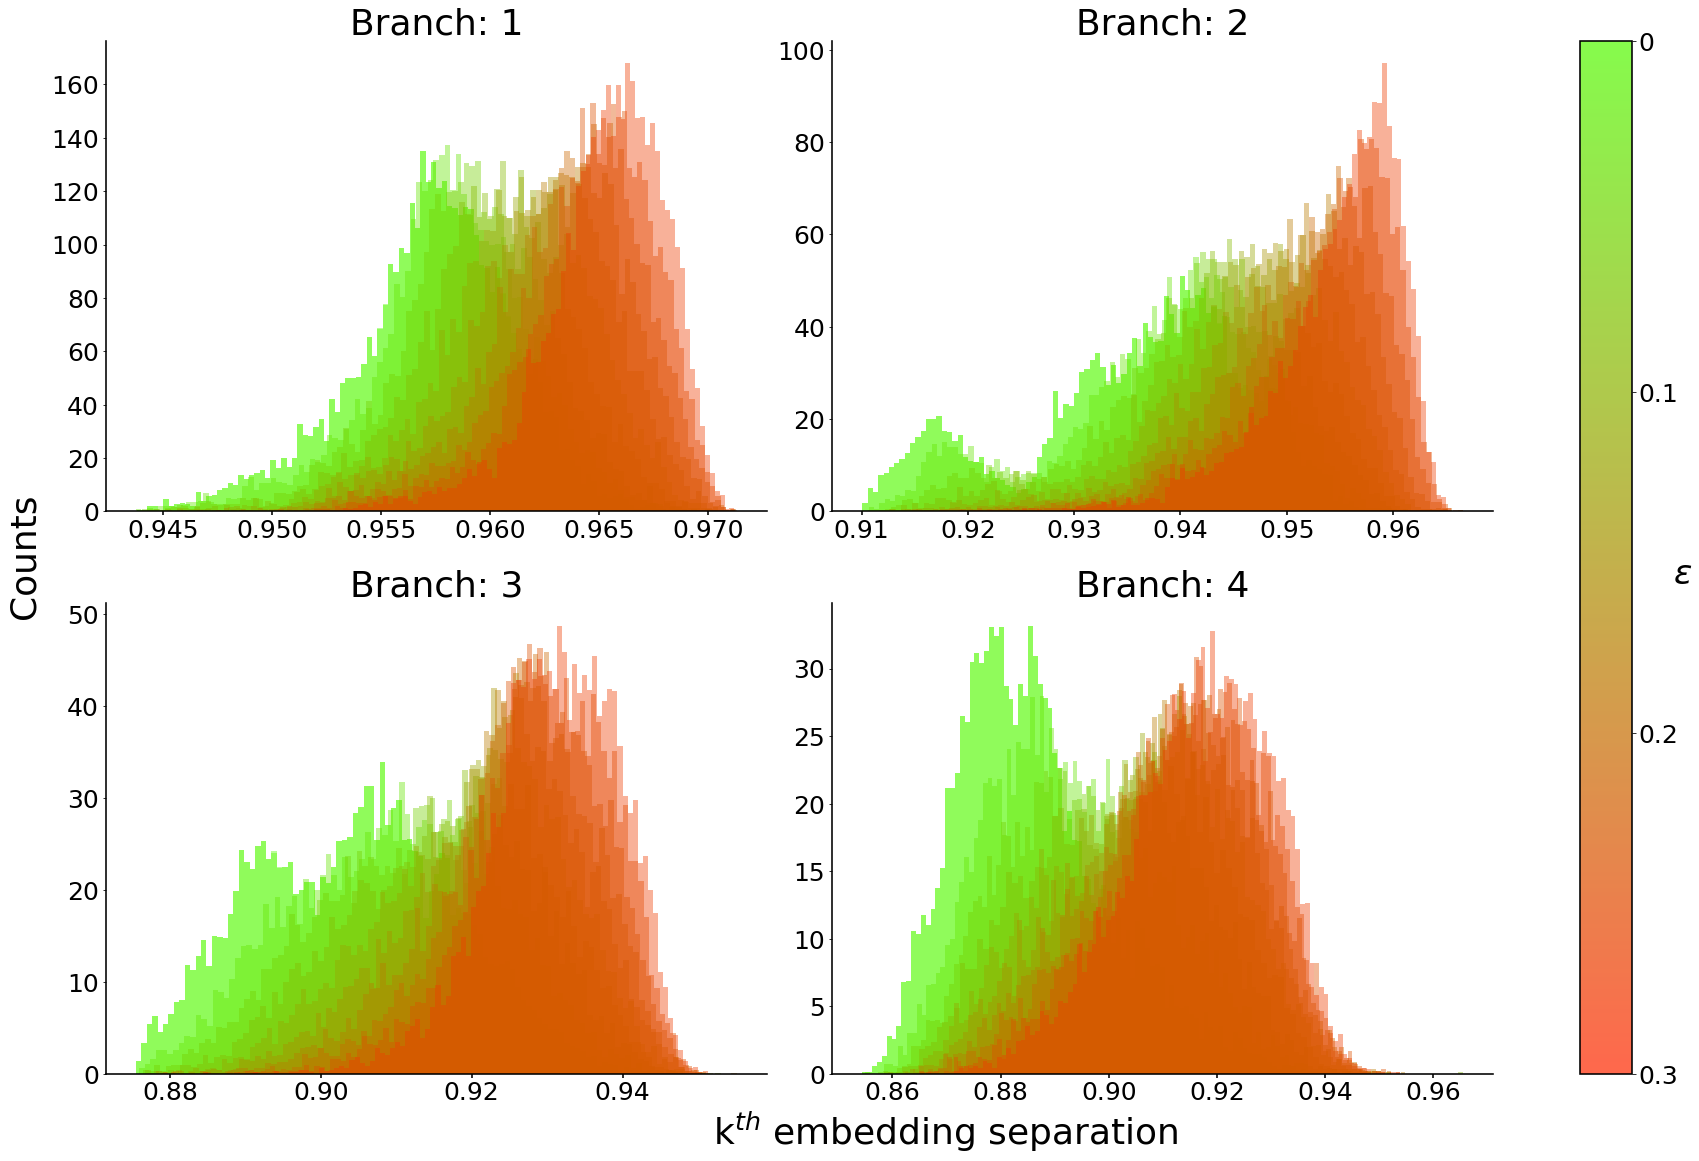

In [3]:
#Taking kth value

green = np.array([83, 250, 0])/255
red = np.array([255, 40, 0])/255
n = 256  # number of values in the colormap
color_list = [green + (red - green) * i / (n - 1) for i in range(n)]
cmap = plt.cm.colors.ListedColormap(color_list[::-1])

model_directory = 'trained-models/CIFAR10/resnet_4_branch/w1.0_d18/300-epoch/'

dataset = 'CIFAR10'

adversarial = np.load(model_directory + '/adversarial_analysis/knn_distances.npy')
epsilons = np.load(model_directory + '/adversarial_analysis/epsilons.npy')

clean_values = np.load(model_directory+'/knn_ood/train_'+dataset+'_train/test_'+dataset+'_test/all_k_distances.npy')[:,:,-1]

n_tests = adversarial.shape[0]
n_branches = adversarial.shape[2]

fig, axes = plt.subplots(2, int(n_branches/2))

for branch,ax in enumerate(axes.flatten()):
    clean_branch = clean_values[:,branch]
    ax.set_title('Branch: '+ str(branch+1))
    ax.hist(clean_branch,bins=n_bins,label='in distribution',alpha=0.4,color=green,density=True)
    # n_high = np.percentile(clean_branch,99)
    # ax.vlines(np.array([n_high]),ymin=0,ymax=50,colors=['black'])
    for ood_test in range(n_tests):
        knn_values = adversarial[ood_test,:,:,:]
        adversarial_branch = knn_values[:,branch,-1]
        ax.hist(adversarial_branch,bins=n_bins,alpha=0.4,density=True,color=cmap(1-(ood_test/n_tests)))

plt.tight_layout()
sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, ax=axes, location='right')
cbar.set_alpha(0.7)
cbar.draw_all()
cbar.set_ticks([0,0.33,0.66,1])
cbar.set_ticklabels([0.3,0.2,0.1,0])

cbar.set_label('$\epsilon$',rotation=0,fontsize=34)

# fig.text(0.5, 0.95, ('Embedding separation with perturbation: $\epsilon$'), ha='center', va='center', rotation='horizontal',fontsize=30)
fig.text(0.0, 0.5, 'Counts', ha='center', va='center', rotation='vertical',fontsize=36)
fig.text(0.5, 0.0, 'k$^{th}$ embedding separation', ha='center', va='center', rotation='horizontal',fontsize=36)
plt.savefig('main/figures/adv_dists.pdf',bbox_inches='tight')
plt.show()

In [3]:
def get_AUROC(directory,epsilons,n_thresh=100,dataset='CIFAR10'):
    clean_values = np.load(directory+'/knn_ood/train_'+dataset+'_train/test_'+dataset+'_test/all_k_distances.npy')[:,:,-1]
    adversarial = np.load(directory + '/adversarial_analysis/knn_distances.npy')[:,:,:,-1]
    n_tests = adversarial.shape[0]
    n_branches = adversarial.shape[2]
    areas = np.zeros((len(epsilons),n_branches))
    thresholds = np.linspace(0,100,n_thresh)
    for test_idx,epsilon in enumerate(epsilons):
        perturbed = adversarial[test_idx,:,:]
        for branch in range(n_branches):
            clean_branch = clean_values[:,branch]
            perturbed_branch = perturbed[:,branch]
            TPR = np.zeros(n_thresh)
            FPR = np.zeros(n_thresh)
            for thresh_idx,thresh in enumerate(thresholds[::-1]):
                threshold = np.percentile(clean_branch,thresh)
                x,y = make_data(clean_branch,perturbed_branch)
                preds = np.array(x>threshold,dtype=int)
                conf_mat = confusion_matrix(y,preds)
                tp = conf_mat[1,1]
                fp = conf_mat[0,1]
                tn = conf_mat[0,0]
                fn = conf_mat[1,0]

                TPR[thresh_idx] = tp/(fn+tp)
                FPR[thresh_idx] = fp/(tn+fp)
            
            areas[test_idx,branch] = np.trapz(TPR,FPR)
    return areas

In [5]:
directories = ['trained-models/CIFAR100/resnet_4_branch/w1.0_d18/300-epoch/',
               'trained-models/CIFAR100/resnet_4_branch/w1.0_d18/300-epoch_1/',
               'trained-models/CIFAR100/resnet_4_branch/w1.0_d18/300-epoch_2/',
               'trained-models/CIFAR100/resnet_4_branch/w1.0_d18/300-epoch_3/',
               'trained-models/CIFAR100/resnet_4_branch/w1.0_d18/300-epoch_4/']
               
epsilons = np.load(directories[0] + '/adversarial_analysis/epsilons.npy')

AUROC_curves = list()

for directory in directories:
    AUROC_curves.append(get_AUROC(directory,epsilons,dataset='CIFAR100'))

all_curves = np.stack(AUROC_curves,axis=0)

np.save(directories[0]+'/adversarial_analysis/AUROC_adv.npy',all_curves) 


In [7]:
model_directory = 'trained-models/CIFAR100/resnet_4_branch/w1.0_d18/300-epoch/'
all_curves = np.load(model_directory+'/adversarial_analysis/AUROC_adv.npy') 

n_branches = 4 

mean_area = np.mean(all_curves,axis=0)
std_area = np.std(all_curves,axis=0)

for test_idx,test in enumerate(epsilons):
    print('Data:',test)
    for branch in range(n_branches):
        print('Branch:',branch+1,np.round(mean_area[test_idx,branch],2),'+-',np.round(std_area[test_idx,branch],2))

Data: 0.0
Branch: 1 0.5 +- 0.0
Branch: 2 0.5 +- 0.0
Branch: 3 0.5 +- 0.0
Branch: 4 0.5 +- 0.0
Data: 0.03333333333333333
Branch: 1 0.54 +- 0.01
Branch: 2 0.58 +- 0.0
Branch: 3 0.58 +- 0.01
Branch: 4 0.59 +- 0.01
Data: 0.06666666666666667
Branch: 1 0.57 +- 0.01
Branch: 2 0.69 +- 0.01
Branch: 3 0.67 +- 0.01
Branch: 4 0.68 +- 0.01
Data: 0.1
Branch: 1 0.58 +- 0.01
Branch: 2 0.77 +- 0.02
Branch: 3 0.75 +- 0.01
Branch: 4 0.75 +- 0.01
Data: 0.13333333333333333
Branch: 1 0.56 +- 0.01
Branch: 2 0.84 +- 0.03
Branch: 3 0.82 +- 0.01
Branch: 4 0.81 +- 0.01
Data: 0.16666666666666666
Branch: 1 0.54 +- 0.01
Branch: 2 0.88 +- 0.03
Branch: 3 0.88 +- 0.01
Branch: 4 0.85 +- 0.01
Data: 0.2
Branch: 1 0.53 +- 0.02
Branch: 2 0.91 +- 0.04
Branch: 3 0.92 +- 0.01
Branch: 4 0.88 +- 0.01
Data: 0.23333333333333334
Branch: 1 0.53 +- 0.02
Branch: 2 0.93 +- 0.04
Branch: 3 0.95 +- 0.01
Branch: 4 0.91 +- 0.02
Data: 0.26666666666666666
Branch: 1 0.52 +- 0.03
Branch: 2 0.94 +- 0.04
Branch: 3 0.96 +- 0.0
Branch: 4 0.92 +- 0

[[0.568 0.568 0.613 0.646]
 [0.64  0.646 0.685 0.725]
 [0.717 0.723 0.749 0.779]
 [0.786 0.789 0.803 0.82 ]
 [0.84  0.842 0.849 0.851]
 [0.882 0.884 0.885 0.877]
 [0.915 0.916 0.913 0.899]
 [0.939 0.938 0.934 0.916]
 [0.957 0.953 0.95  0.931]]
[0.03 0.07 0.1  0.13 0.17 0.2  0.23 0.27 0.3 ]


/home/jd5u19/Progressive Transformers/transformer-env/lib/python3.7/site-packages/ipykernel_launcher.py:65: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


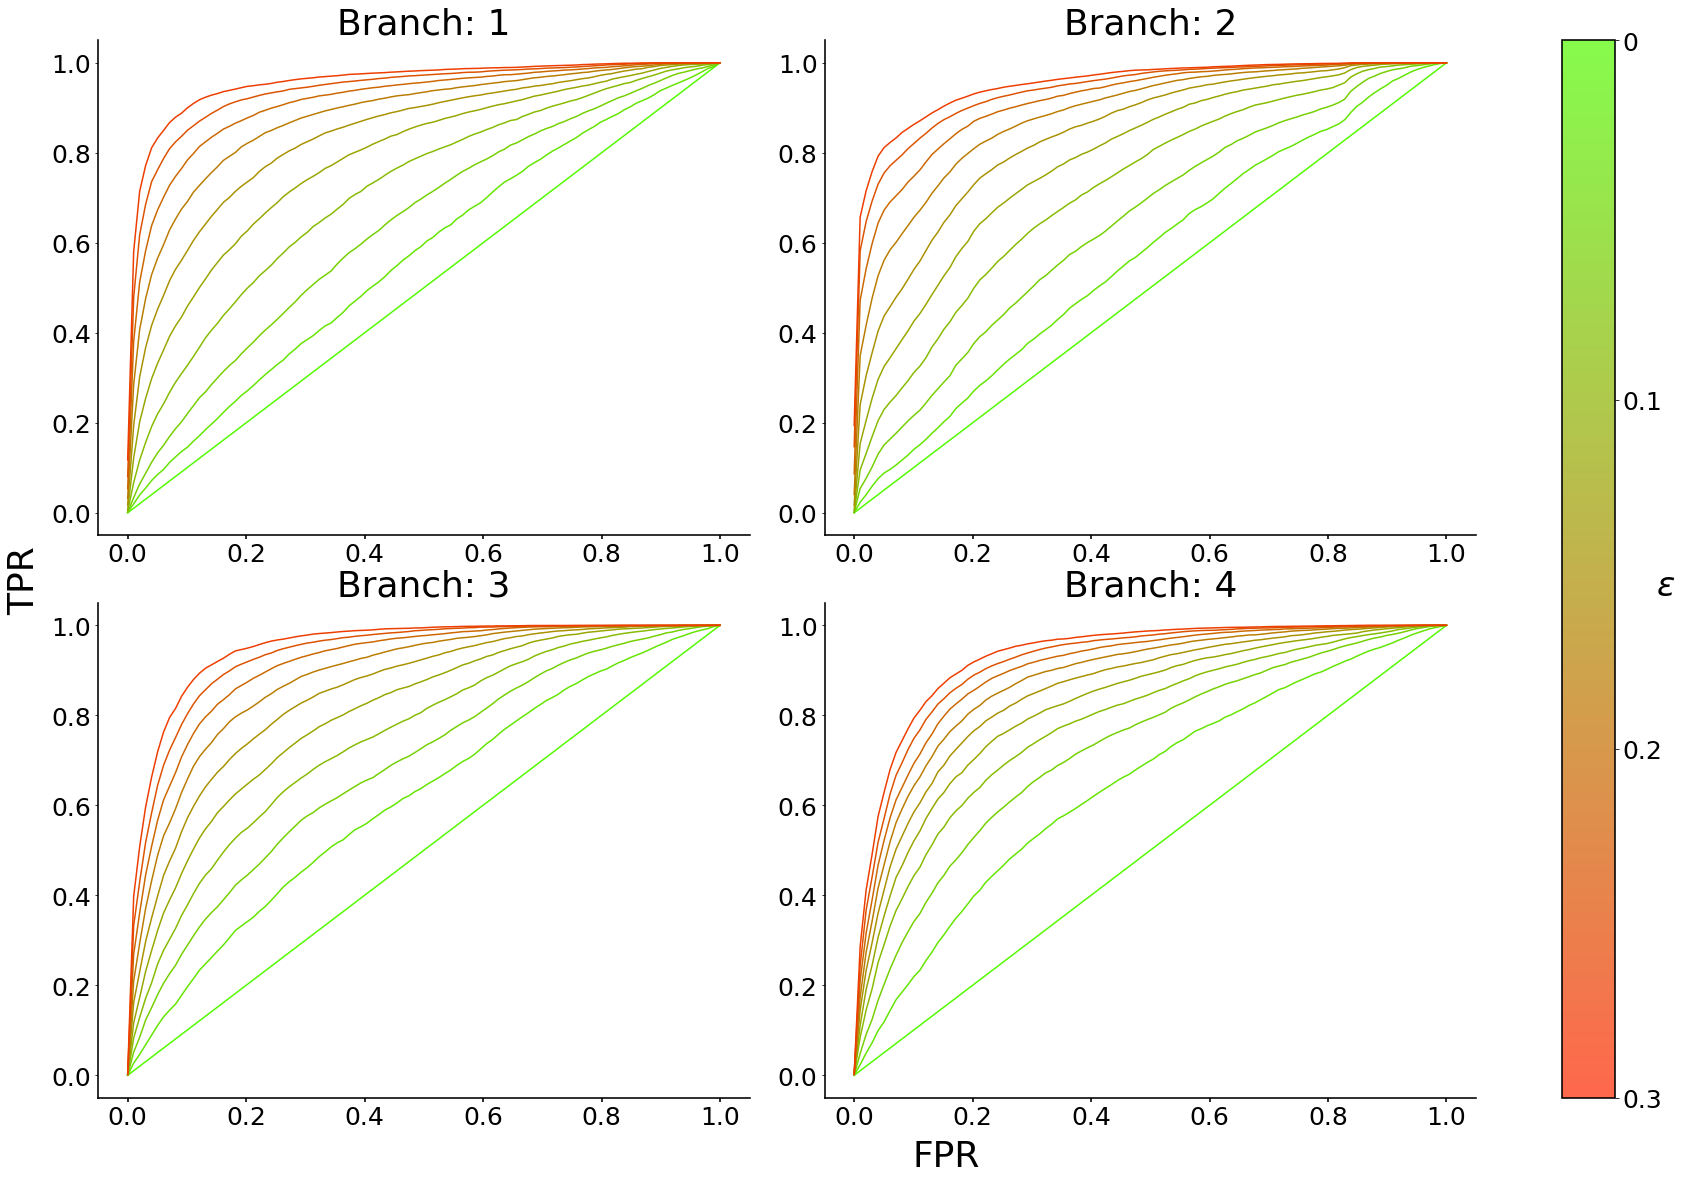

In [7]:
n_thresh = 100
thresholds = np.linspace(0,100,n_thresh)

green = np.array([83, 250, 0])/255
red = np.array([255, 40, 0])/255
n = 256  # number of values in the colormap
color_list = [green + (red - green) * i / (n - 1) for i in range(n)]
cmap = plt.cm.colors.ListedColormap(color_list[::-1])

model_directory = 'trained-models/CIFAR10/resnet_4_branch/w1.0_d18/300-epoch/'

dataset = 'CIFAR10'

adversarial = np.load(model_directory + '/adversarial_analysis/knn_distances.npy')[:,:,:,-1]
epsilons = np.load(model_directory + '/adversarial_analysis/epsilons.npy')

clean_values = np.load(model_directory+'/knn_ood/train_'+dataset+'_train/test_'+dataset+'_test/all_k_distances.npy')[:,:,-1]


n_tests = adversarial.shape[0]
n_branches = adversarial.shape[2]

fig, axes = plt.subplots(2, int(n_branches/2))
plt.tight_layout()
areas = np.zeros((n_tests,n_branches))

for perturbation in range(n_tests):
    perturbed = adversarial[perturbation,:,:]
    for branch,ax in enumerate(axes.flatten()):
        clean_branch = clean_values[:,branch]
        perturbed_branch = perturbed[:,branch]
        TPR = np.zeros(n_thresh)
        FPR = np.zeros(n_thresh)
        decision_boundaries = np.zeros(n_thresh)
        for thresh_idx,thresh in enumerate(thresholds[::-1]):
            threshold = np.percentile(clean_branch,thresh)
            x,y = make_data(clean_branch,perturbed_branch)
            preds = np.array(x>threshold,dtype=int)
            conf_mat = confusion_matrix(y,preds)
            tp = conf_mat[1,1]
            fp = conf_mat[0,1]
            tn = conf_mat[0,0]
            fn = conf_mat[1,0]

            TPR[thresh_idx] = tp/(fn+tp)
            FPR[thresh_idx] = fp/(tn+fp)
        
        AUROC = np.trapz(TPR,FPR)
        areas[perturbation,branch] = AUROC
        ax.set_title('Branch: '+str(branch+1))
        ax.plot(FPR,TPR,color=cmap(1-(perturbation/n_tests)),label=('$\epsilon$'+str(round(epsilons[perturbation],2))+' : '+str(round(AUROC,3))))
        # ax.legend(title='AUROC')
        # ax.vlines([0.05],0.05,0.95)
        # ax.grid(which='major',color='grey', alpha=0.3,linestyle='--', linewidth=1)

print(np.round(areas[1:],3))    
print(np.round(epsilons[1:],2)) 

# fig.text(0.5, 0.95, ('Adversarial example detection ROC'), ha='center', va='center', rotation='horizontal',fontsize=30)
fig.text(0.0, 0.5, 'TPR', ha='center', va='center', rotation='vertical',fontsize=36)
fig.text(0.5, 0.0, 'FPR', ha='center', va='center', rotation='horizontal',fontsize=36)

sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, ax=axes, location='right')
cbar.set_alpha(0.7)
cbar.draw_all()
cbar.set_ticks([0,0.33,0.66,1])
cbar.set_ticklabels([0.3,0.2,0.1,0])

cbar.set_label('$\epsilon$',rotation=0,fontsize=34)
plt.savefig('main/figures/adv_roc.pdf',bbox_inches='tight')
plt.show()

In [4]:
import numpy as np
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx, array[idx]

def log_spacing(value,n_thresh):
    diff = 1-value
    logs = np.logspace(-2,0,n_thresh)
    return logs*diff + value  


def run_adversarial_inference(model_directory,train_dataset,epsilon,n_thresh=100,knn_percentile=0.95,detect_ood=True,adaptive=False):
    func_outputs = dict()
    name = model_directory.split('/')[3] + ' -- ' + model_directory.split('/')[4]

    id_outputs = np.load(model_directory+'/outputs.npy')
    n_branches = id_outputs.shape[1]
    id_labels = np.load(model_directory+'/labels.npy')

    powers = np.load(model_directory+'/power_usage.npy')
    epsilons = np.load(model_directory+'/../adversarial_analysis/epsilons.npy')
    accuracies = np.load(model_directory+'/../adversarial_analysis/accuracies.npy')

    index,_ = find_nearest(epsilons,epsilon)

    id_knn = np.load(model_directory+'/../knn_ood/train_'+train_dataset+'_train/test_'+train_dataset+'_test/all_k_distances.npy')
    adversarial_knn = np.load(model_directory+'/../adversarial_analysis/knn_distances.npy')[index,:,:,:]

    branch_predictions = np.argmax(id_outputs,axis=2)

    n_id_inputs = branch_predictions.shape[0]
    n_ood_inputs = adversarial_knn.shape[0]

    ood_labels = np.full(n_ood_inputs,-1)
    all_labels = np.concatenate([id_labels,ood_labels])

    id_entropies = np.zeros((n_id_inputs,n_branches))
    for input_idx in range(n_id_inputs):
        for branch_idx in range(n_branches):
            id_entropies[input_idx,branch_idx] = entropy(id_outputs[input_idx,branch_idx,:])
    
    id_exits = np.zeros((n_thresh,n_id_inputs,n_branches))
    id_predictions = np.zeros((n_thresh,n_id_inputs))

    ood_exits = np.zeros((n_thresh,n_ood_inputs,n_branches))
    ood_predictions = np.zeros((n_thresh,n_ood_inputs))

    power_usage = np.zeros(n_thresh)

    max_entropy = np.log(id_outputs.shape[2])  
    thresholds = np.linspace(max_entropy,0,n_thresh)

    knn_thresholds = np.zeros((n_branches,n_thresh))
    for branch in range(n_branches):
        id_branch = id_knn[:,branch,-1]
        knn_thresholds[branch,:] = np.percentile(id_branch,knn_percentile*100)
        if adaptive == True: 
            # adaptive_index = int(n_thresh/2)
            # percentiles=np.linspace(knn_percentile,1,n_thresh-(adaptive_index+1))
            percentiles=log_spacing(knn_percentile,n_thresh)
            for p_idx,percentile in enumerate(percentiles):
                knn_thresh = np.percentile(id_branch,percentile*100)
                # knn_thresholds[branch,p_idx+adaptive_index+1] = knn_thresh
                knn_thresholds[branch,p_idx] = knn_thresh
    
    for thresh_idx,threshold in enumerate(thresholds):
        #get ID outputs w/ knn 
        for inp_idx in range(n_id_inputs):
            early_exit = False
            for branch_idx,branch_entropy in enumerate(id_entropies[inp_idx,:]):
                if id_knn[inp_idx,branch_idx,-1] > knn_thresholds[branch_idx,thresh_idx]:
                    id_exits[thresh_idx,inp_idx,branch_idx] = 1
                    id_predictions[thresh_idx,inp_idx] = -1
                    early_exit=True
                    break
                if branch_entropy < threshold:
                    id_exits[thresh_idx,inp_idx,branch_idx] = 1
                    id_predictions[thresh_idx,inp_idx] = branch_predictions[inp_idx,branch_idx] 
                    early_exit=True
                    break
            if early_exit == False:
                id_exits[thresh_idx,inp_idx,(n_branches-1)] = 1
                id_predictions[thresh_idx,inp_idx] = branch_predictions[inp_idx,(n_branches-1)]

        #get OOD knn outputs w/ entropy
        for inp_idx in range(n_ood_inputs):
            if not detect_ood:
                ood_exits[:,:,(n_branches-1)] = 1
                ood_predictions[:,:] = -2
                break
            early_exit = False
            for branch_idx,knn_distance in enumerate(adversarial_knn[inp_idx,:,-1]):
                if knn_distance > knn_thresholds[branch_idx,thresh_idx]:
                    ood_exits[thresh_idx,inp_idx,branch_idx] = 1
                    ood_predictions[thresh_idx,inp_idx] = -1
                    early_exit=True
                    break
            if early_exit == False:
                ood_exits[thresh_idx,inp_idx,(n_branches-1)] = 1
                if accuracies[inp_idx,-1,index] == 1:
                    ood_predictions[thresh_idx,inp_idx] = -1
                else:
                    ood_predictions[thresh_idx,inp_idx] = -2

        all_exits = np.concatenate([id_exits,ood_exits],axis=1) 
        power_usage[thresh_idx] = np.dot(np.sum(all_exits[thresh_idx,:],axis=0),powers)
        all_predictions = np.concatenate([id_predictions,ood_predictions],axis=1) 

    ood_accuracy = np.zeros(n_thresh)
    id_accuracy = np.zeros(n_thresh)
    all_accuracy = np.zeros(n_thresh)
    for thresh in range(n_thresh):
        id_accuracy[thresh] = np.mean(id_predictions[thresh,:] == id_labels) 
        ood_accuracy[thresh] = np.mean(ood_predictions[thresh,:] == ood_labels) 
        all_accuracy[thresh] = np.mean(all_predictions[thresh,:] == all_labels) 
    
    func_outputs['all_predictions'] = all_predictions
    func_outputs['power_usage'] = power_usage/len(all_labels)
    func_outputs['all_labels'] = all_labels
    func_outputs['all_exits'] = all_exits
    func_outputs['id_predictions'] = id_predictions
    func_outputs['id_labels'] = id_labels
    func_outputs['ood_labels'] = ood_labels
    func_outputs['id_accuracy'] = id_accuracy
    func_outputs['ood_accuracy'] = ood_accuracy
    func_outputs['all_accuracy'] = all_accuracy
    func_outputs['n_id_samples'] = n_id_inputs
    func_outputs['n_ood_samples'] = n_ood_inputs


    return func_outputs


def plot_ood_power(ax,model_directory,data,epsilon,n_thresh,percentile,detect_ood=True,adaptive=False):
    if detect_ood==False:
        label = 'None'
    else:
        label = str(percentile)
    func_out = run_adversarial_inference(model_directory,data,epsilon,n_thresh=n_thresh,knn_percentile=percentile,detect_ood=detect_ood,adaptive=adaptive)
    ax.plot(func_out['power_usage'],func_out['id_accuracy'],label=label)
    standard_error = 1/np.sqrt(func_out['n_id_samples'])
    ax.fill_between(func_out['power_usage'],func_out['id_accuracy']-standard_error,func_out['id_accuracy']+standard_error,alpha=0.3)

def plot_improvement_power_adv(ax,model_directory,data,epsilon,n_thresh,percentile,detect_ood=True,adaptive=False):
    base_value_dict = run_adversarial_inference(model_directory,data,epsilon,n_thresh=n_thresh,knn_percentile=1.0,detect_ood=False,adaptive=False)
    base_power,base_acc=base_value_dict['power_usage'],base_value_dict['id_accuracy']

    func_out = run_adversarial_inference(model_directory,data,epsilon,n_thresh=n_thresh,knn_percentile=percentile,detect_ood=detect_ood,adaptive=adaptive)
    power,acc=func_out['power_usage'],func_out['id_accuracy']
    
    acc_range = np.linspace(base_acc[0],np.max(acc),500)
    max_acc = np.max(base_acc)
    interp_power = np.interp(acc_range,base_acc,base_power)

    if detect_ood==False:
        label = 'None'
    else:
        label = str(percentile)

    interp_power_test = np.interp(acc_range,acc,power)
    power_diff = ((interp_power-interp_power_test)/interp_power)*100
    cutoff_idx = np.argmin(power_diff>0)
    if cutoff_idx == 0:
        cutoff_idx=len(interp_power_test-1)

    acc_range=(max_acc-acc_range)*100
    
    ax.plot(acc_range[:cutoff_idx],power_diff[:cutoff_idx],label=label)

    sigma=3
    interval = sigma*np.sqrt(power_diff/func_out['n_id_samples'])

    ax.fill_between(acc_range[:cutoff_idx],power_diff[:cutoff_idx]-interval[:cutoff_idx],power_diff[:cutoff_idx]+interval[:cutoff_idx],alpha=0.3)

Using closest value for epsilon: 0.0
Using closest value for epsilon: 0.1
Using closest value for epsilon: 0.2
Using closest value for epsilon: 0.3


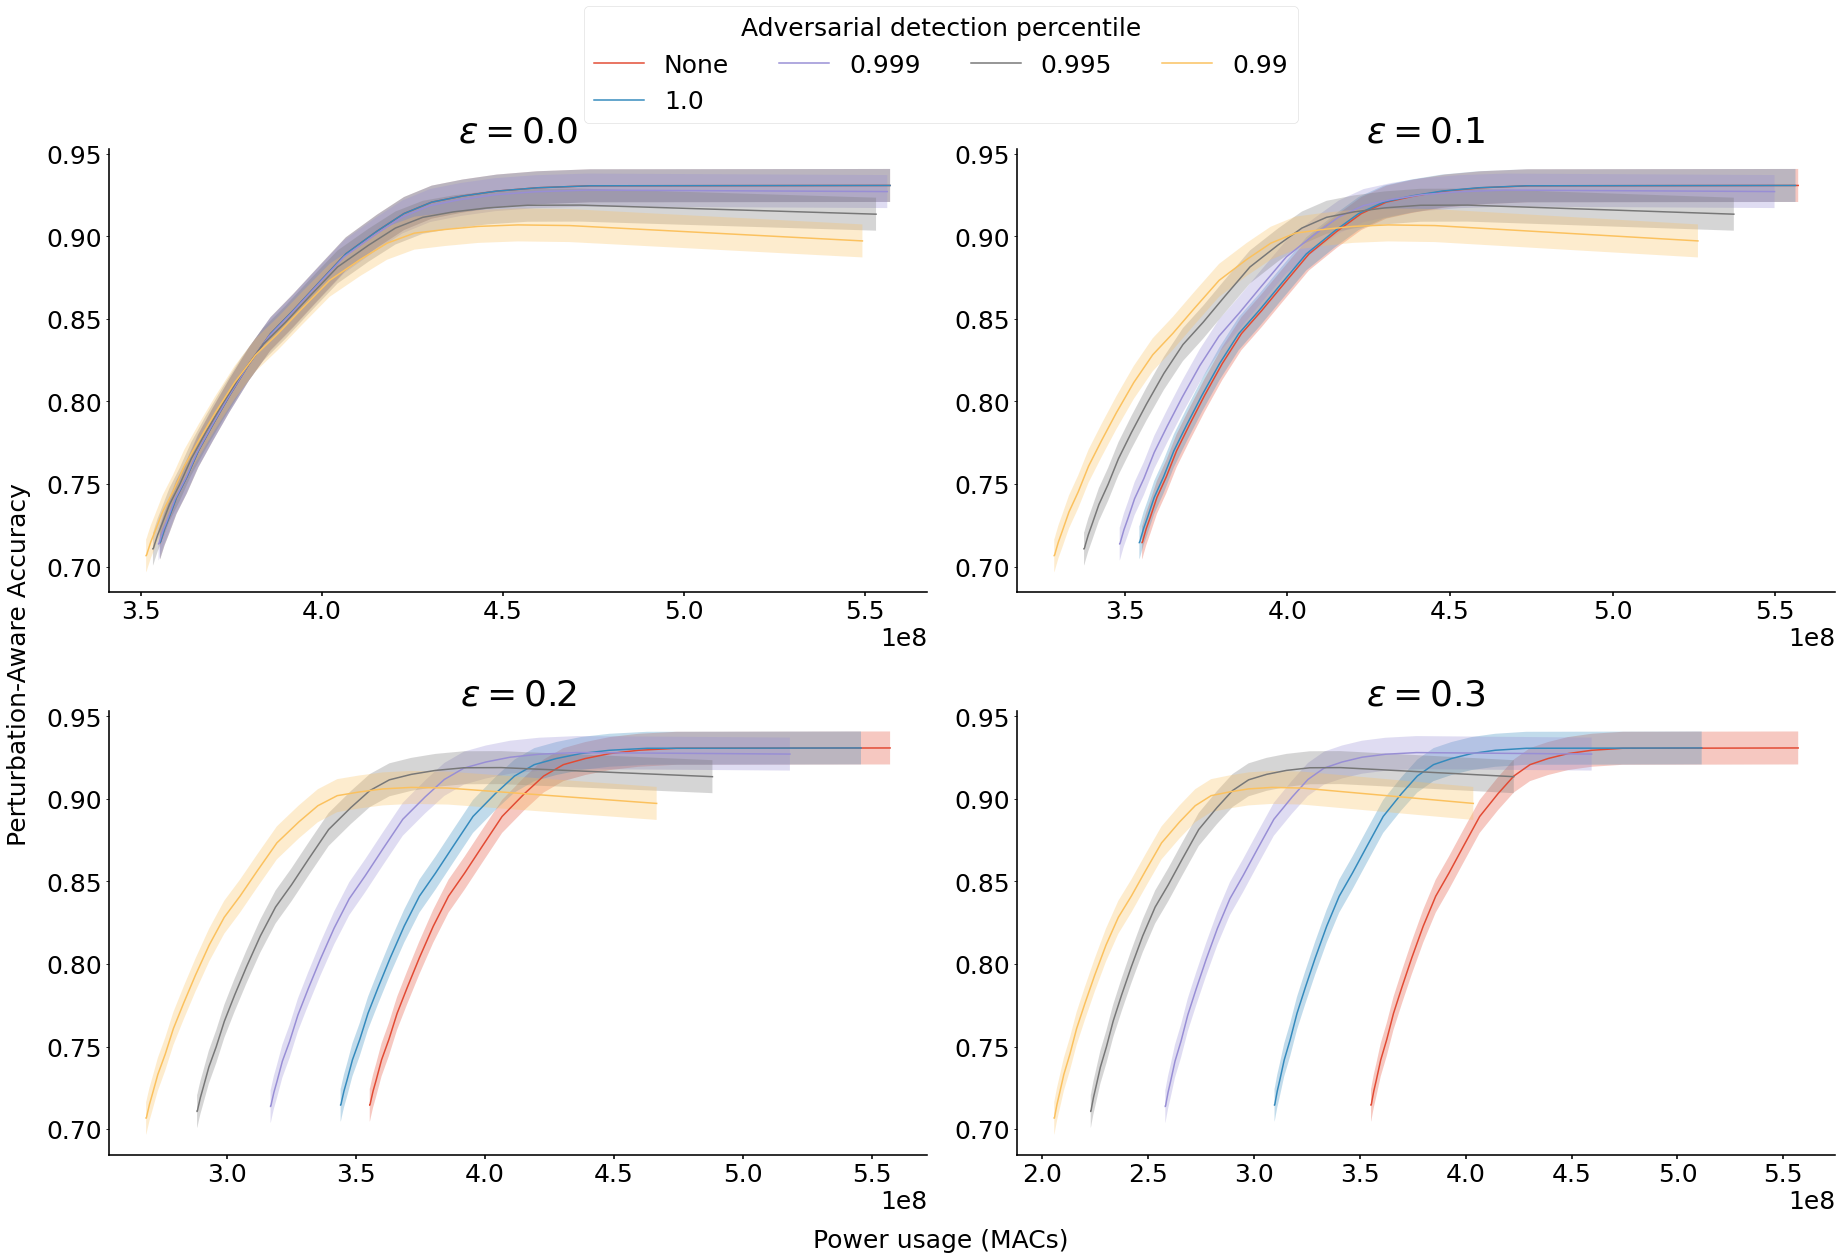

In [9]:
model_directory = 'trained-models/CIFAR10/resnet_4_branch/w1.0_d18/300-epoch/analysis'
n_tests = 4
fig, axes = plt.subplots(2, 2,figsize=(width,height))
knn_ood_tests = np.linspace(0,0.3,n_tests)

for test_idx,epsilon in enumerate(knn_ood_tests):
    _,epsilon = find_nearest(epsilons,epsilon)
    print('Using closest value for epsilon:',epsilon)
    ax = axes.flatten()[test_idx]
    ax.set_title('$\epsilon = $'+ str(round(epsilon,2)))
    plot_ood_power(ax,model_directory,'CIFAR10',epsilon,n_thresh=25,percentile=1.0,detect_ood=False)
    plot_ood_power(ax,model_directory,'CIFAR10',epsilon,n_thresh=25,percentile=1.0,detect_ood=True)
    plot_ood_power(ax,model_directory,'CIFAR10',epsilon,n_thresh=25,percentile=0.999,detect_ood=True)
    plot_ood_power(ax,model_directory,'CIFAR10',epsilon,n_thresh=25,percentile=0.995,detect_ood=True)
    plot_ood_power(ax,model_directory,'CIFAR10',epsilon,n_thresh=25,percentile=0.99,detect_ood=True)
    
# plt.ylabel('OOD-Aware Accuracy')
# plt.xlabel('Power usage (MACs)')
h, l = axes.flatten()[-1].get_legend_handles_labels()
legend = fig.legend(h,l,title='Adversarial detection percentile',loc='center',bbox_to_anchor=(0.5,1.02),ncol=len(knn_ood_tests))
plt.setp(legend.get_title(), multialignment='center')
plt.tight_layout()

# fig.text(0.5, 0.95, ('OOD detection ROC'), ha='center', va='center', rotation='horizontal',fontsize=30)
fig.text(0.0, 0.5, 'Perturbation-Aware Accuracy', ha='center', va='center', rotation='vertical')
fig.text(0.5, 0, 'Power usage (MACs)', ha='center', va='center', rotation='horizontal')
plt.savefig('main/figures/adv_powers.pdf',bbox_inches='tight')
plt.show()

Using closest value for epsilon: 0.0
Using closest value for epsilon: 0.1
Using closest value for epsilon: 0.2
Using closest value for epsilon: 0.3


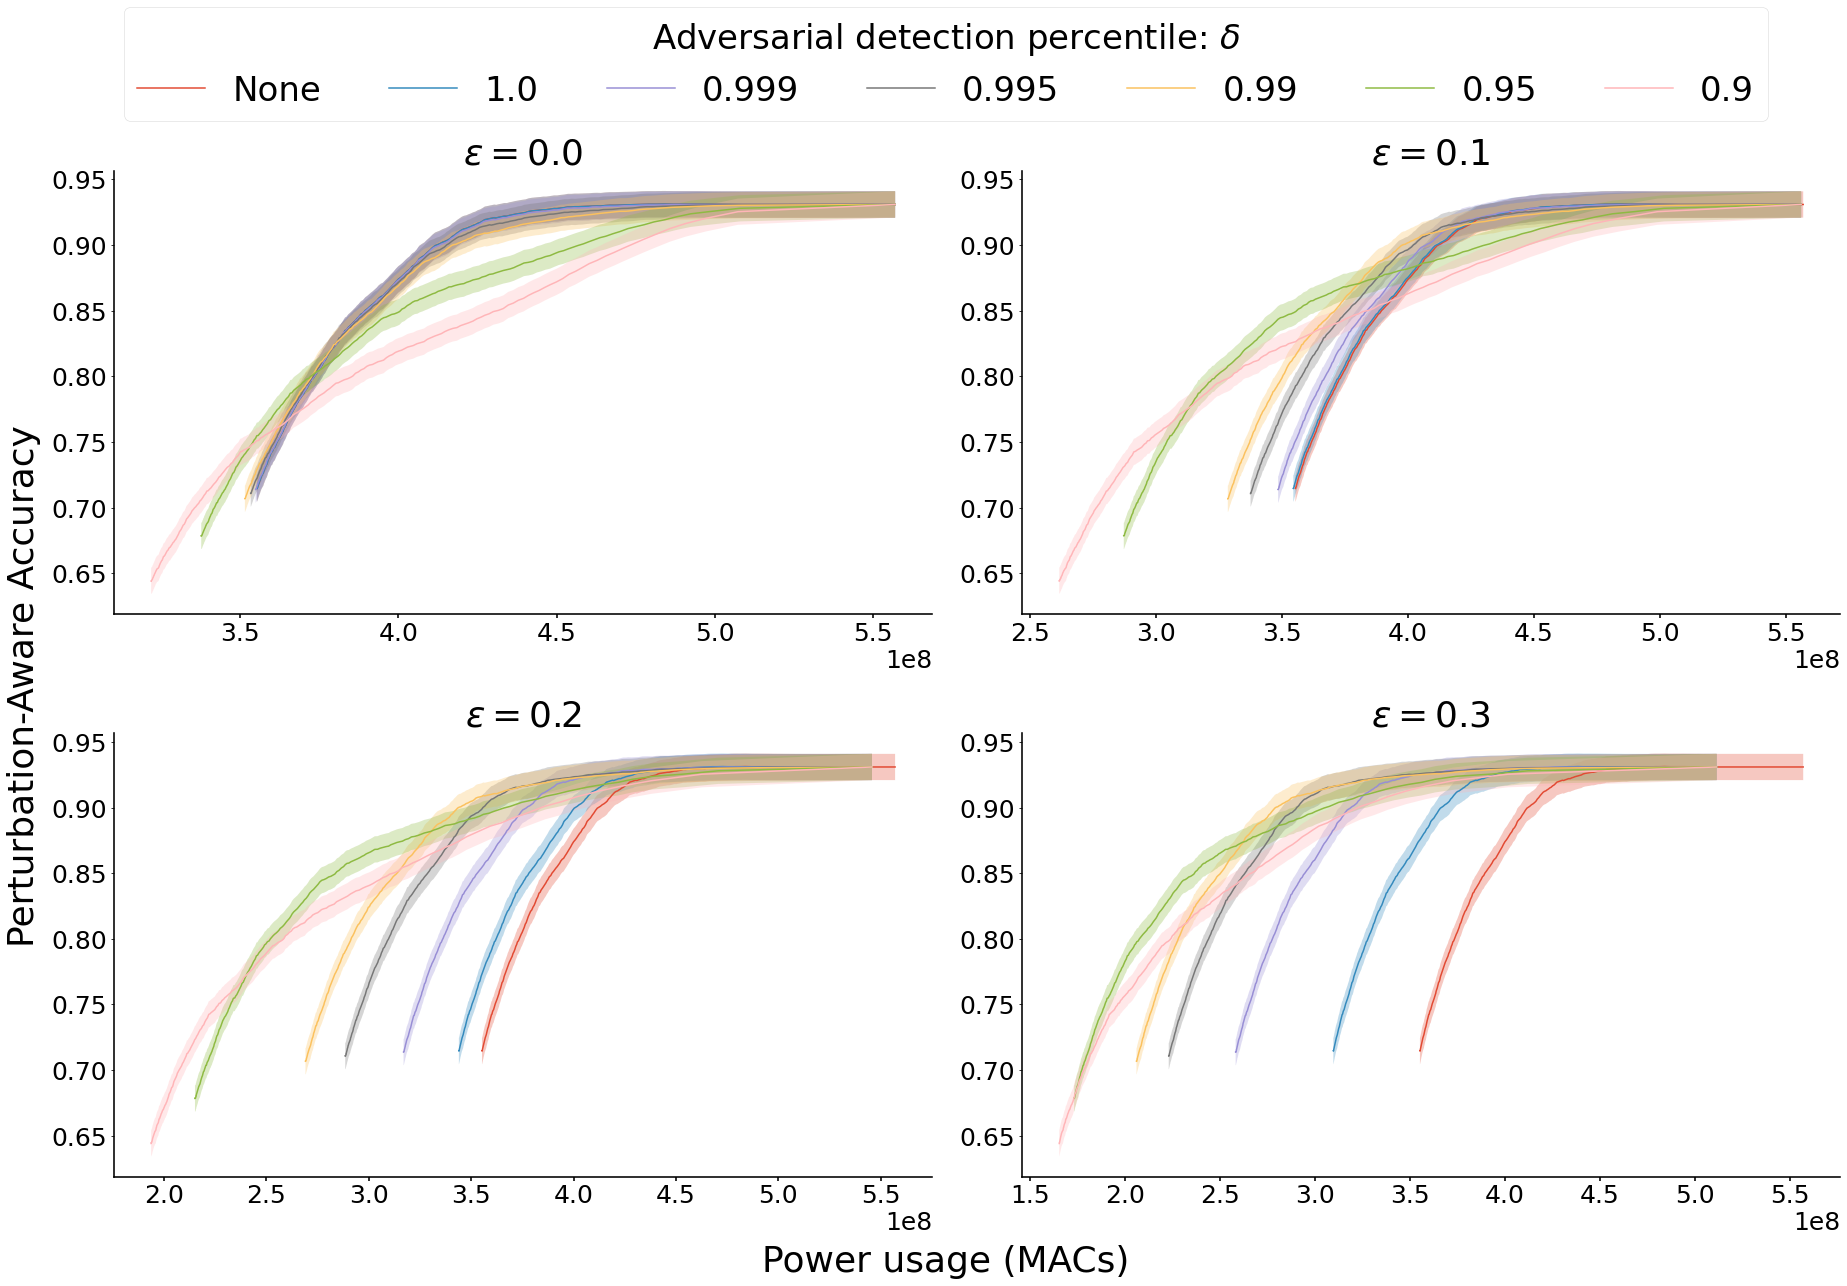

In [10]:
model_directory = 'trained-models/CIFAR10/resnet_4_branch/w1.0_d18/300-epoch/analysis'
n_tests = 4
fig, axes = plt.subplots(2, 2, figsize= (width,height))
knn_ood_tests = np.linspace(0,0.3,n_tests)

for test_idx,epsilon in enumerate(knn_ood_tests):
    _,epsilon = find_nearest(epsilons,epsilon)
    print('Using closest value for epsilon:',epsilon)
    ax = axes.flatten()[test_idx]
    ax.set_title('$\epsilon = $'+ str(round(epsilon,2)))
    plot_ood_power(ax,model_directory,'CIFAR10',epsilon,n_thresh=250,percentile=1.0,detect_ood=False)
    plot_ood_power(ax,model_directory,'CIFAR10',epsilon,n_thresh=250,percentile=1.0,detect_ood=True)
    plot_ood_power(ax,model_directory,'CIFAR10',epsilon,n_thresh=250,percentile=0.999,detect_ood=True,adaptive=True)
    plot_ood_power(ax,model_directory,'CIFAR10',epsilon,n_thresh=250,percentile=0.995,detect_ood=True,adaptive=True)
    plot_ood_power(ax,model_directory,'CIFAR10',epsilon,n_thresh=250,percentile=0.99,detect_ood=True,adaptive=True)
    plot_ood_power(ax,model_directory,'CIFAR10',epsilon,n_thresh=250,percentile=0.95,detect_ood=True,adaptive=True)
    plot_ood_power(ax,model_directory,'CIFAR10',epsilon,n_thresh=250,percentile=0.9,detect_ood=True,adaptive=True)
    
# plt.ylabel('OOD-Aware Accuracy')
# plt.xlabel('Power usage (MACs)')
h, l = axes.flatten()[-1].get_legend_handles_labels()
legend = fig.legend(h,l,title='Adversarial detection percentile: $\delta$',loc='center',bbox_to_anchor=(0.5,1.04),ncol=7,fontsize=34)
plt.setp(legend.get_title(), multialignment='center',fontsize=34)
plt.tight_layout()

# fig.text(0.5, 0.95, ('OOD detection ROC'), ha='center', va='center', rotation='horizontal',fontsize=30)
fig.text(0.0, 0.5, 'Perturbation-Aware Accuracy', ha='center', va='center', rotation='vertical',fontsize=36)
fig.text(0.5, 0, 'Power usage (MACs)', ha='center', va='center', rotation='horizontal',fontsize=36)
plt.savefig('main/figures/adv_powers_adaptive.pdf',bbox_inches='tight')
plt.show()

Using closest value for epsilon: 0.0


/home/jd5u19/Progressive Transformers/transformer-env/lib/python3.7/site-packages/ipykernel_launcher.py:172: RuntimeWarning: invalid value encountered in sqrt
/home/jd5u19/Progressive Transformers/transformer-env/lib/python3.7/site-packages/ipykernel_launcher.py:172: RuntimeWarning: invalid value encountered in sqrt
/home/jd5u19/Progressive Transformers/transformer-env/lib/python3.7/site-packages/ipykernel_launcher.py:172: RuntimeWarning: invalid value encountered in sqrt
/home/jd5u19/Progressive Transformers/transformer-env/lib/python3.7/site-packages/ipykernel_launcher.py:172: RuntimeWarning: invalid value encountered in sqrt
/home/jd5u19/Progressive Transformers/transformer-env/lib/python3.7/site-packages/ipykernel_launcher.py:172: RuntimeWarning: invalid value encountered in sqrt


Using closest value for epsilon: 0.06666666666666667


/home/jd5u19/Progressive Transformers/transformer-env/lib/python3.7/site-packages/ipykernel_launcher.py:172: RuntimeWarning: invalid value encountered in sqrt
/home/jd5u19/Progressive Transformers/transformer-env/lib/python3.7/site-packages/ipykernel_launcher.py:172: RuntimeWarning: invalid value encountered in sqrt
/home/jd5u19/Progressive Transformers/transformer-env/lib/python3.7/site-packages/ipykernel_launcher.py:172: RuntimeWarning: invalid value encountered in sqrt
/home/jd5u19/Progressive Transformers/transformer-env/lib/python3.7/site-packages/ipykernel_launcher.py:172: RuntimeWarning: invalid value encountered in sqrt
/home/jd5u19/Progressive Transformers/transformer-env/lib/python3.7/site-packages/ipykernel_launcher.py:172: RuntimeWarning: invalid value encountered in sqrt


Using closest value for epsilon: 0.13333333333333333


/home/jd5u19/Progressive Transformers/transformer-env/lib/python3.7/site-packages/ipykernel_launcher.py:172: RuntimeWarning: invalid value encountered in sqrt
/home/jd5u19/Progressive Transformers/transformer-env/lib/python3.7/site-packages/ipykernel_launcher.py:172: RuntimeWarning: invalid value encountered in sqrt
/home/jd5u19/Progressive Transformers/transformer-env/lib/python3.7/site-packages/ipykernel_launcher.py:172: RuntimeWarning: invalid value encountered in sqrt
/home/jd5u19/Progressive Transformers/transformer-env/lib/python3.7/site-packages/ipykernel_launcher.py:172: RuntimeWarning: invalid value encountered in sqrt
/home/jd5u19/Progressive Transformers/transformer-env/lib/python3.7/site-packages/ipykernel_launcher.py:172: RuntimeWarning: invalid value encountered in sqrt


Using closest value for epsilon: 0.16666666666666666


/home/jd5u19/Progressive Transformers/transformer-env/lib/python3.7/site-packages/ipykernel_launcher.py:172: RuntimeWarning: invalid value encountered in sqrt
/home/jd5u19/Progressive Transformers/transformer-env/lib/python3.7/site-packages/ipykernel_launcher.py:172: RuntimeWarning: invalid value encountered in sqrt
/home/jd5u19/Progressive Transformers/transformer-env/lib/python3.7/site-packages/ipykernel_launcher.py:172: RuntimeWarning: invalid value encountered in sqrt
/home/jd5u19/Progressive Transformers/transformer-env/lib/python3.7/site-packages/ipykernel_launcher.py:172: RuntimeWarning: invalid value encountered in sqrt
/home/jd5u19/Progressive Transformers/transformer-env/lib/python3.7/site-packages/ipykernel_launcher.py:172: RuntimeWarning: invalid value encountered in sqrt


Using closest value for epsilon: 0.23333333333333334


/home/jd5u19/Progressive Transformers/transformer-env/lib/python3.7/site-packages/ipykernel_launcher.py:172: RuntimeWarning: invalid value encountered in sqrt
/home/jd5u19/Progressive Transformers/transformer-env/lib/python3.7/site-packages/ipykernel_launcher.py:172: RuntimeWarning: invalid value encountered in sqrt
/home/jd5u19/Progressive Transformers/transformer-env/lib/python3.7/site-packages/ipykernel_launcher.py:172: RuntimeWarning: invalid value encountered in sqrt
/home/jd5u19/Progressive Transformers/transformer-env/lib/python3.7/site-packages/ipykernel_launcher.py:172: RuntimeWarning: invalid value encountered in sqrt
/home/jd5u19/Progressive Transformers/transformer-env/lib/python3.7/site-packages/ipykernel_launcher.py:172: RuntimeWarning: invalid value encountered in sqrt


Using closest value for epsilon: 0.3


/home/jd5u19/Progressive Transformers/transformer-env/lib/python3.7/site-packages/ipykernel_launcher.py:172: RuntimeWarning: invalid value encountered in sqrt
/home/jd5u19/Progressive Transformers/transformer-env/lib/python3.7/site-packages/ipykernel_launcher.py:172: RuntimeWarning: invalid value encountered in sqrt
/home/jd5u19/Progressive Transformers/transformer-env/lib/python3.7/site-packages/ipykernel_launcher.py:172: RuntimeWarning: invalid value encountered in sqrt
/home/jd5u19/Progressive Transformers/transformer-env/lib/python3.7/site-packages/ipykernel_launcher.py:172: RuntimeWarning: invalid value encountered in sqrt
/home/jd5u19/Progressive Transformers/transformer-env/lib/python3.7/site-packages/ipykernel_launcher.py:172: RuntimeWarning: invalid value encountered in sqrt


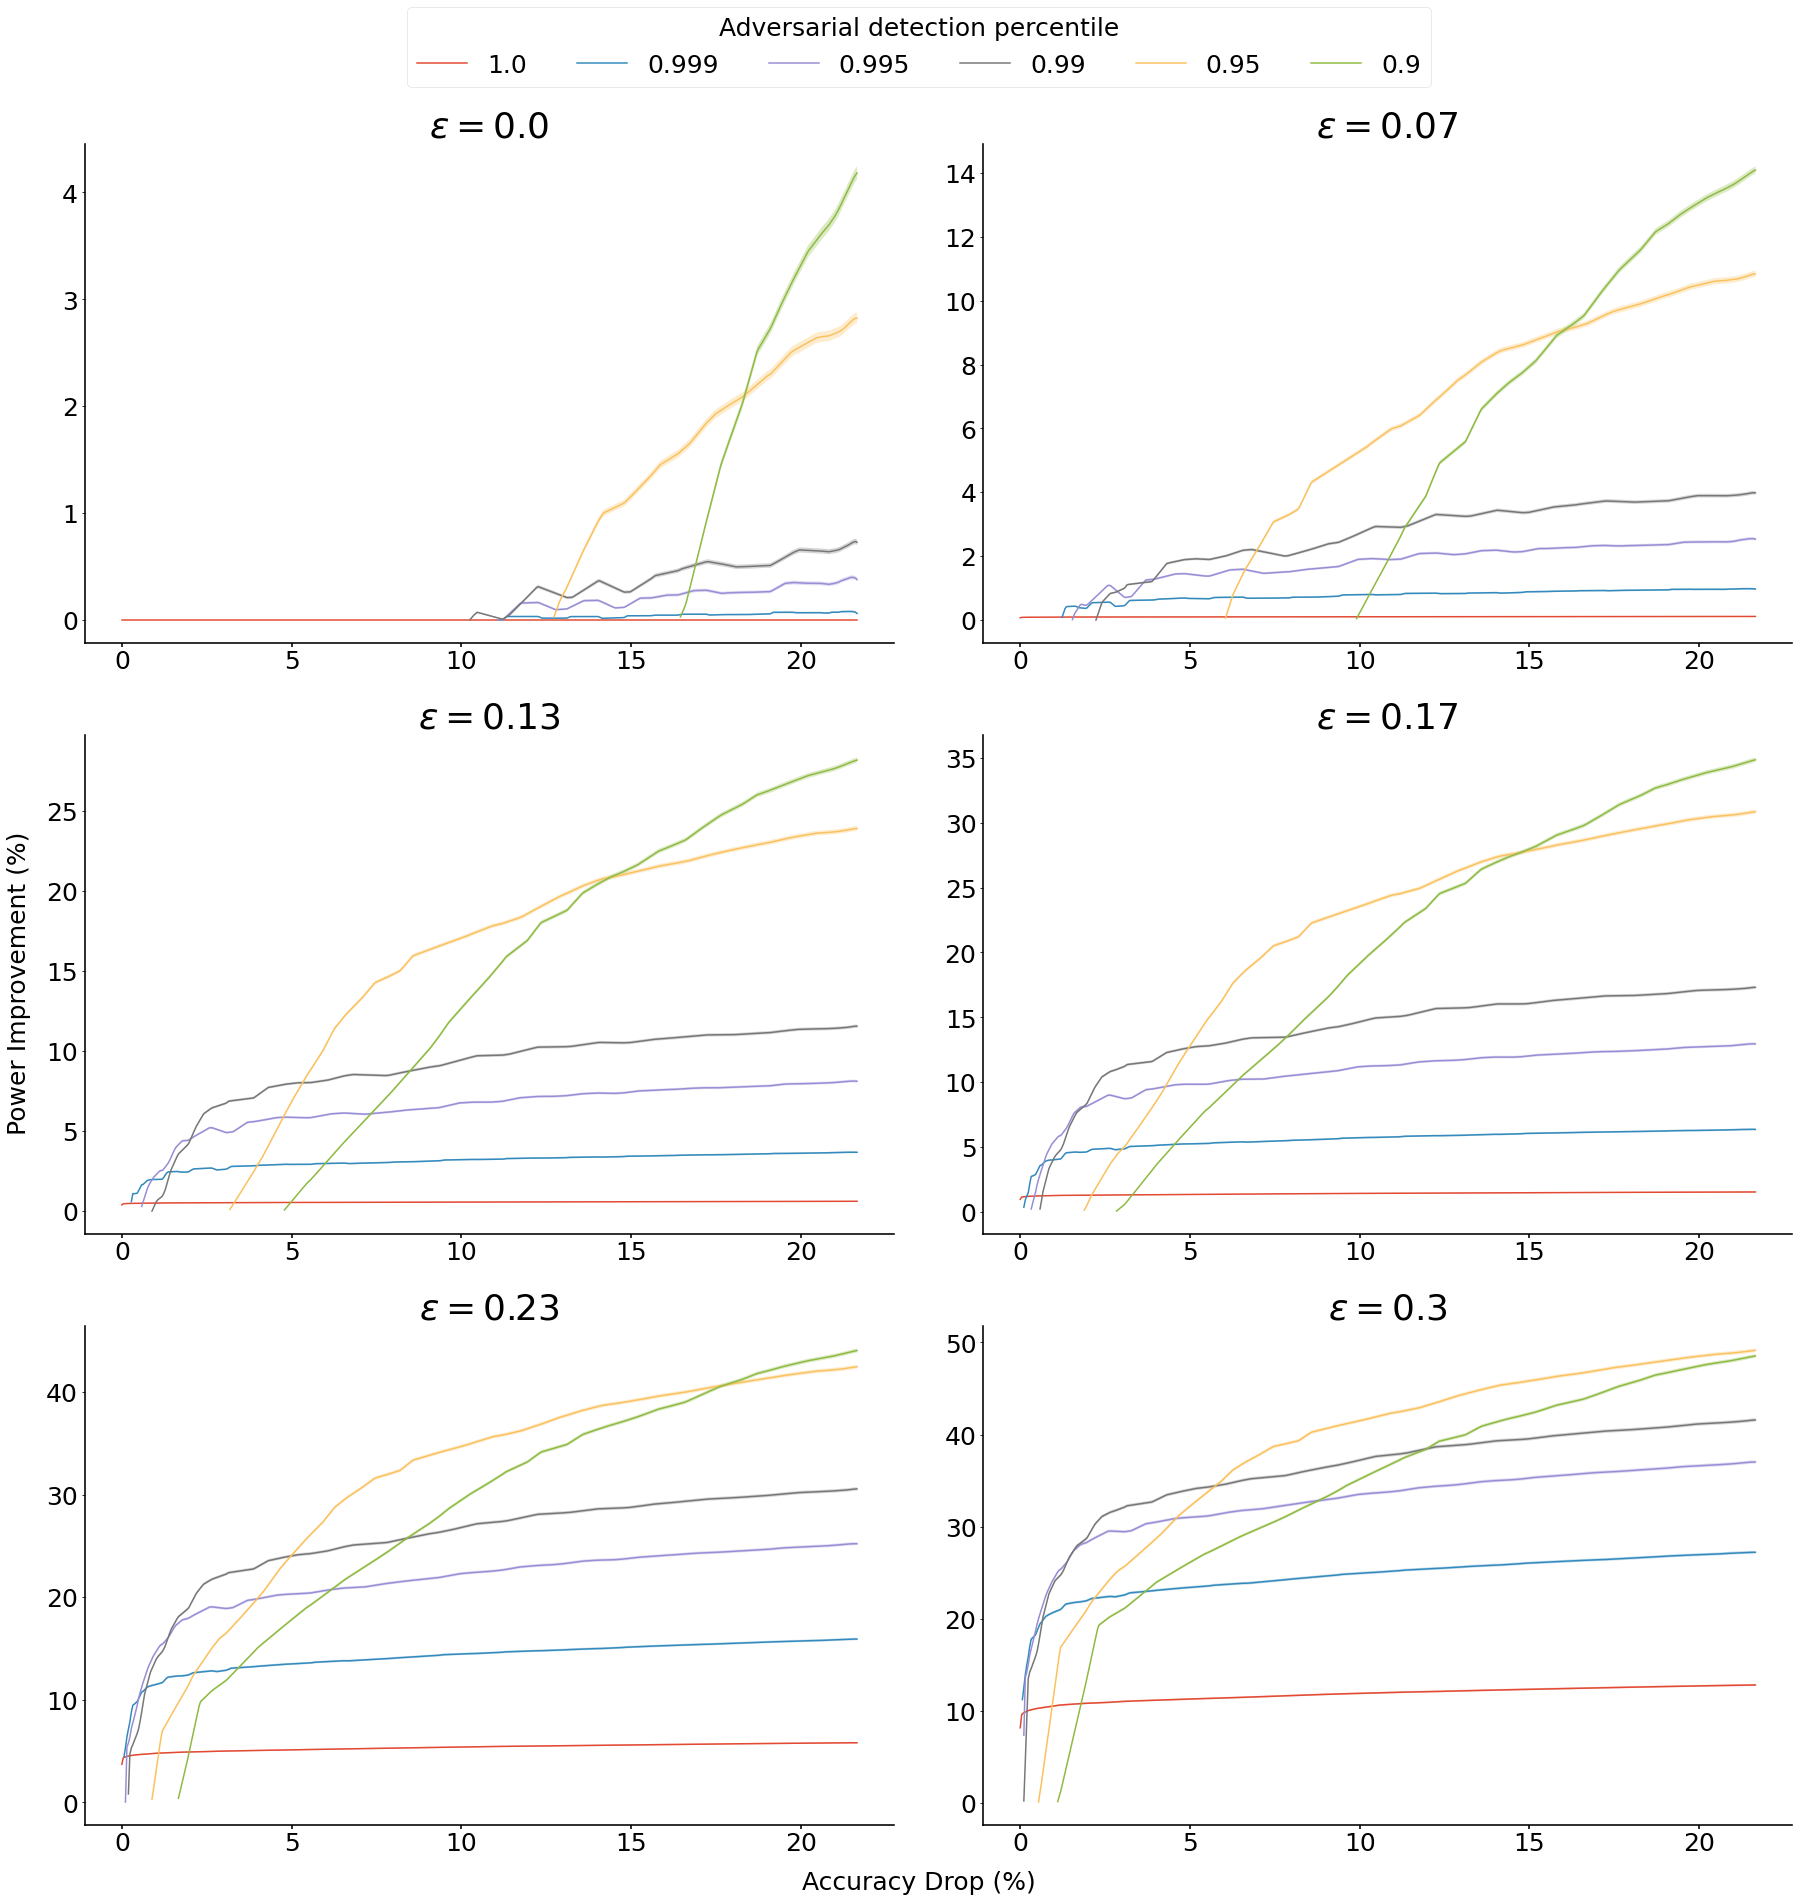

In [11]:
model_directory = 'trained-models/CIFAR10/resnet_4_branch/w1.0_d18/300-epoch/analysis'
n_tests = 6
fig, axes = plt.subplots(3, int(n_tests/3),figsize=(25, 25))
knn_ood_tests = np.linspace(0,0.3,n_tests)

for test_idx,epsilon in enumerate(knn_ood_tests):
    _,epsilon = find_nearest(epsilons,epsilon)
    print('Using closest value for epsilon:',epsilon)
    ax = axes.flatten()[test_idx]
    ax.set_title('$\epsilon = $'+ str(round(epsilon,2))) 
    plot_improvement_power_adv(ax,model_directory,'CIFAR10',epsilon,n_thresh=50,percentile=1.0,detect_ood=True)
    plot_improvement_power_adv(ax,model_directory,'CIFAR10',epsilon,n_thresh=50,percentile=0.999,adaptive=True)
    plot_improvement_power_adv(ax,model_directory,'CIFAR10',epsilon,n_thresh=50,percentile=0.995,adaptive=True)
    plot_improvement_power_adv(ax,model_directory,'CIFAR10',epsilon,n_thresh=50,percentile=0.99,adaptive=True)
    plot_improvement_power_adv(ax,model_directory,'CIFAR10',epsilon,n_thresh=50,percentile=0.95,adaptive=True)
    plot_improvement_power_adv(ax,model_directory,'CIFAR10',epsilon,n_thresh=50,percentile=0.9,adaptive=True)
    # ax.invert_xaxis()
    
# plt.ylabel('OOD-Aware Accuracy')
# plt.xlabel('Power usage (MACs)')
h, l = axes.flatten()[-1].get_legend_handles_labels()
legend = fig.legend(h,l,title='Adversarial detection percentile',loc='center',bbox_to_anchor=(0.5,1.02),ncol=len(knn_ood_tests))
plt.setp(legend.get_title(), multialignment='center')
plt.tight_layout()

# fig.text(0.5, 0.95, ('OOD detection ROC'), ha='center', va='center', rotation='horizontal',fontsize=30)
fig.text(0.5, 0.0,  'Accuracy Drop (%)',ha='center', va='center', rotation='horizontal')
fig.text(0.0, 0.5, 'Power Improvement (%)', ha='center', va='center', rotation='vertical')
plt.savefig('main/figures/power_improvement_adv.pdf',bbox_inches='tight')
plt.show()

In [18]:
def plot_adv_accuracy(ax,model_directory,data,ood_data,n_thresh,percentile,detect_ood=True,adaptive=False):
    base_value_dict = run_adversarial_inference(model_directory,data,ood_data,n_thresh=n_thresh,knn_percentile=1.0,detect_ood=False,adaptive=False)
    base_acc=base_value_dict['id_accuracy']

    func_out = run_adversarial_inference(model_directory,data,ood_data,n_thresh=n_thresh,knn_percentile=percentile,detect_ood=detect_ood,adaptive=adaptive)
    id_acc,ood_acc=func_out['id_accuracy'],func_out['ood_accuracy']
    
    acc_range = np.linspace(min(base_acc),max(base_acc),500)

    max_acc = max(base_acc)

    label = str(percentile)
    if adaptive:
        label = label + ' adaptive'

    interp_ood_acc_test = np.interp(acc_range,id_acc,ood_acc)*100

    acc_range = (acc_range/max_acc)*100
    
    ax.plot(acc_range,interp_ood_acc_test,label=label)

    sigma=3
    interval = sigma*np.sqrt(interp_ood_acc_test/func_out['n_id_samples'])

    ax.fill_between(acc_range,interp_ood_acc_test-interval,interp_ood_acc_test+interval,alpha=0.3)

    targets = np.array([100,99,95,90])
    key_indices = list()

    for target in targets:
        key_indices.append(np.abs(acc_range - target).argmin())

    
    return np.round(acc_range[key_indices],0),np.round(interp_ood_acc_test[key_indices],3)

Using closest value for epsilon: 0.0
0.0 0.999 (array([100.,  99.,  95.,  90.,  85.,  80.]), array([93.09, 93.2 , 93.22, 93.23, 93.23, 93.23]))
0.0 0.995 (array([100.,  99.,  95.,  90.,  85.,  80.]), array([93.09 , 93.452, 93.591, 93.641, 93.68 , 93.68 ]))
0.0 0.99 (array([100.,  99.,  95.,  90.,  85.,  80.]), array([93.09 , 93.547, 93.904, 94.02 , 94.07 , 94.1  ]))
0.0 0.99 (array([100.,  99.,  95.,  90.,  85.,  80.]), array([93.09 , 93.528, 94.905, 95.996, 96.269, 96.358]))
0.0 0.99 (array([100.,  99.,  95.,  90.,  85.,  80.]), array([93.09 , 93.461, 94.867, 96.521, 97.398, 97.676]))
Using closest value for epsilon: 0.1
0.1 0.999 (array([100.,  99.,  95.,  90.,  85.,  80.]), array([33.9  , 36.712, 37.409, 37.575, 37.668, 37.749]))
0.1 0.995 (array([100.,  99.,  95.,  90.,  85.,  80.]), array([33.9  , 40.389, 43.072, 43.705, 44.128, 44.284]))
0.1 0.99 (array([100.,  99.,  95.,  90.,  85.,  80.]), array([33.9  , 42.335, 47.415, 48.484, 49.203, 49.414]))
0.1 0.99 (array([100.,  99.,  95

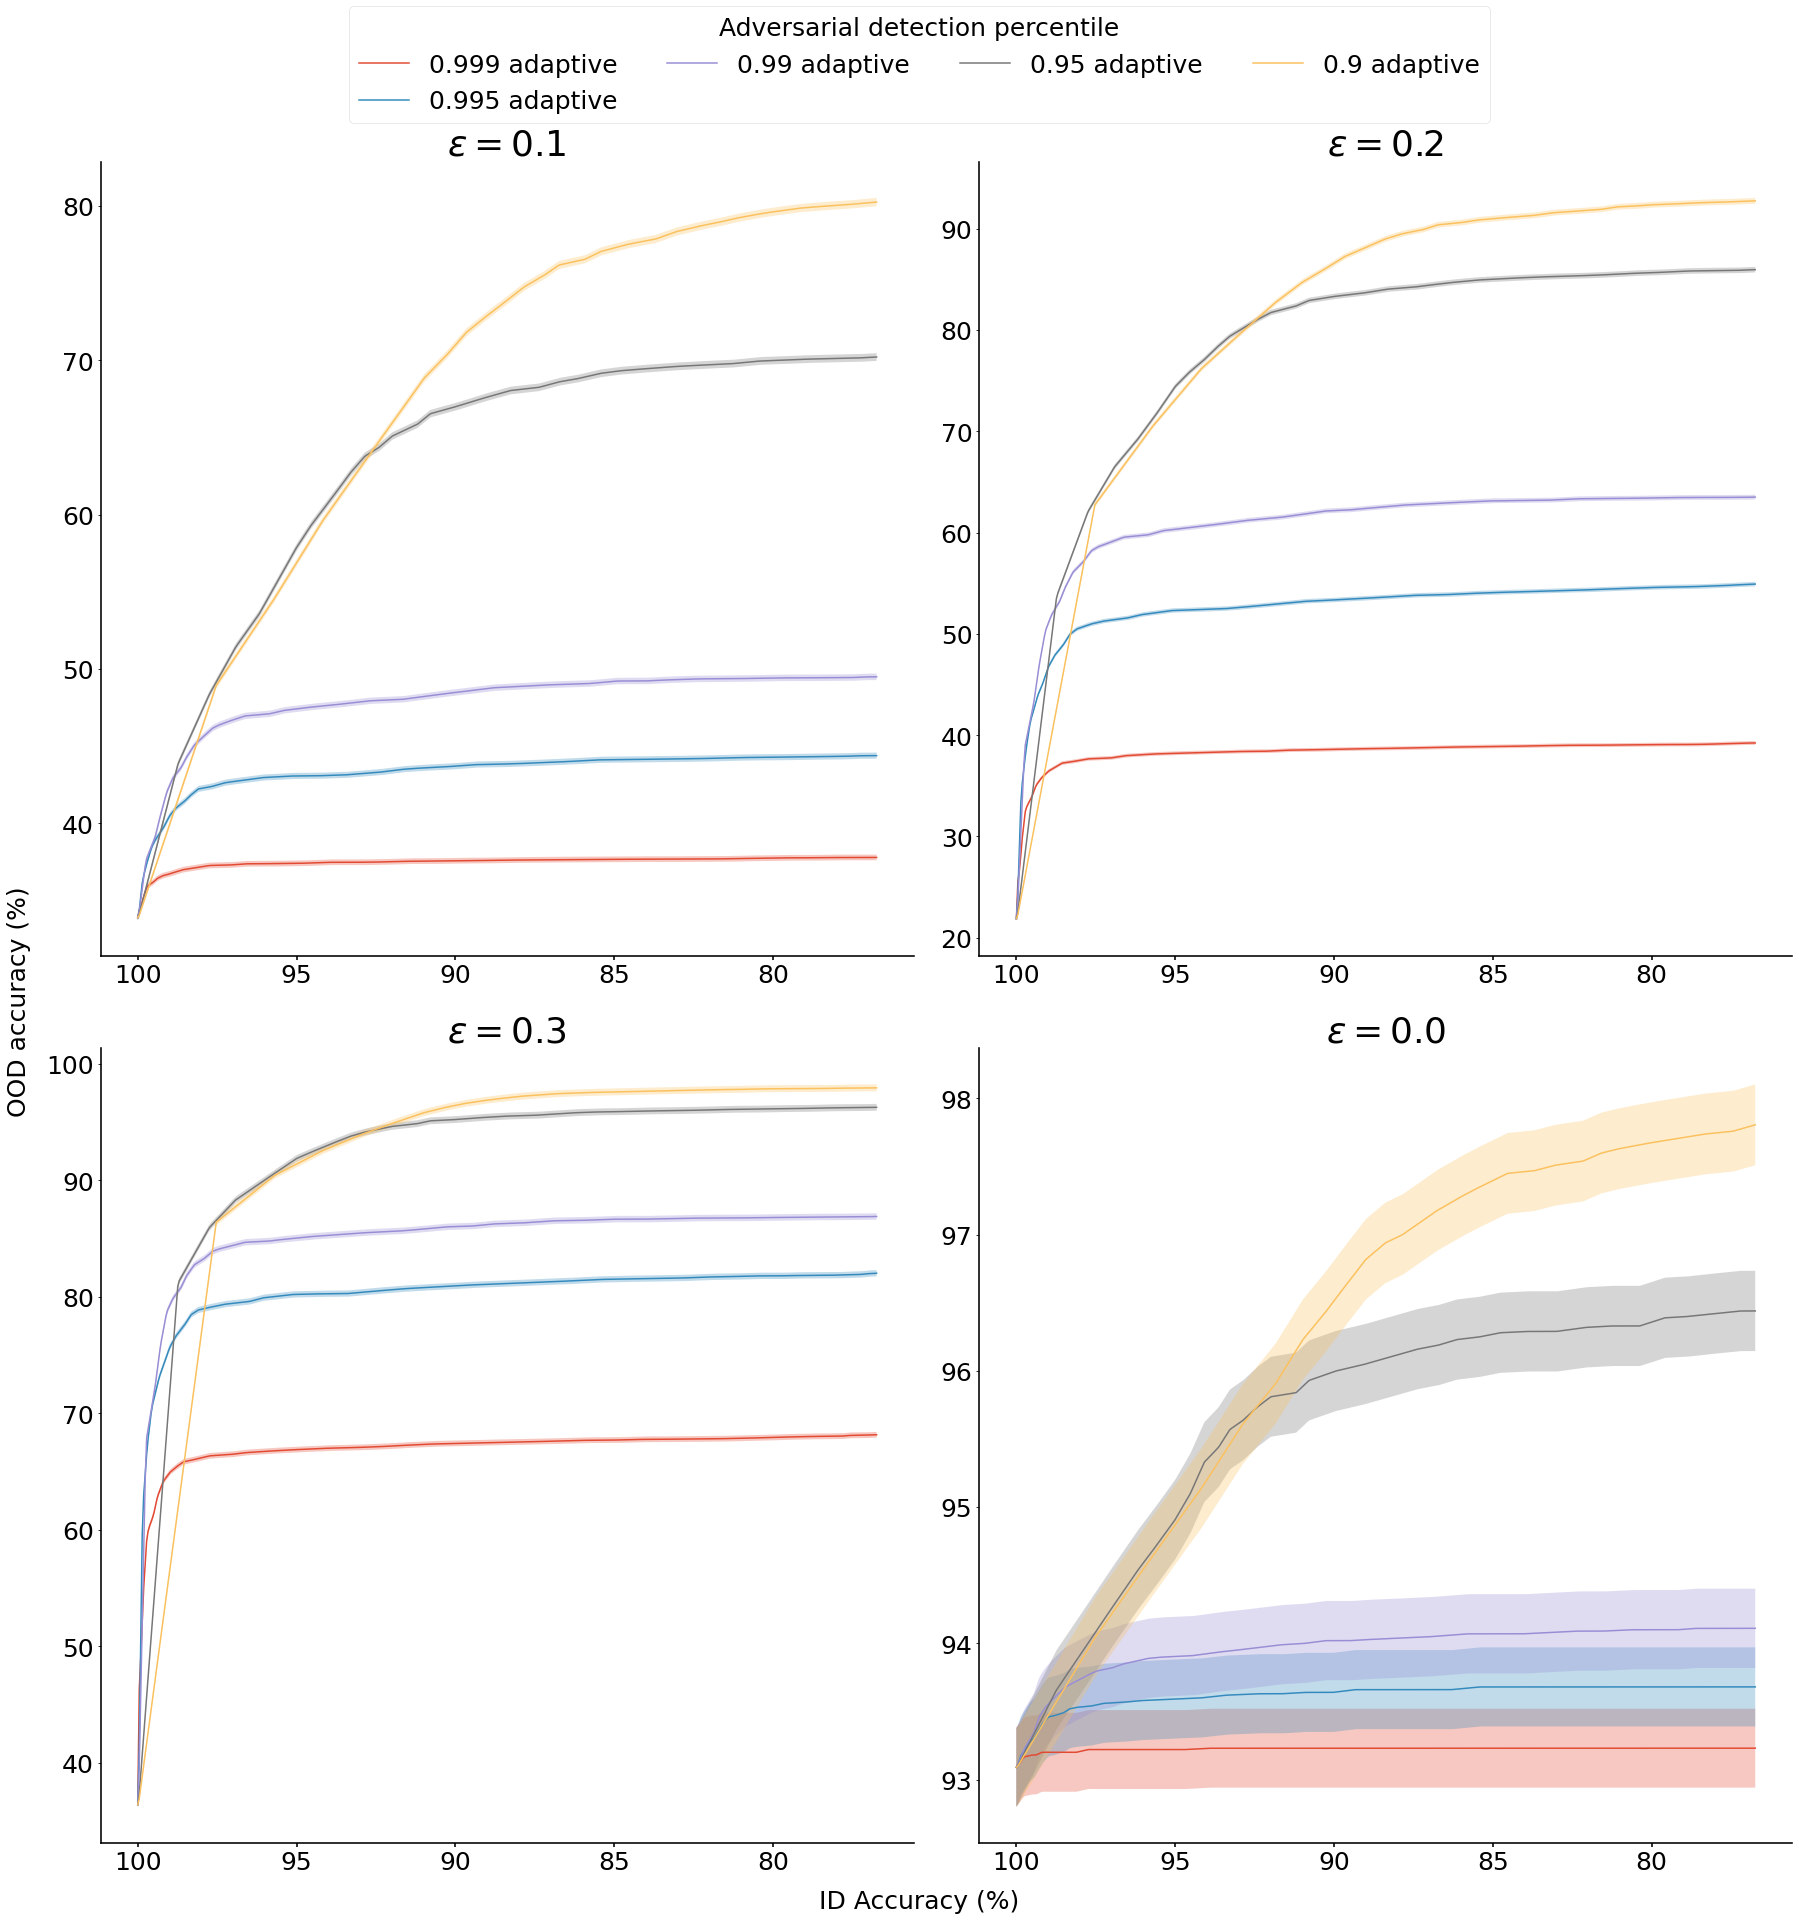

In [13]:
model_directory = 'trained-models/CIFAR10/resnet_4_branch/w1.0_d18/300-epoch/analysis'
n_tests = 10
fig, axes = plt.subplots(2, 2,figsize=(25, 25))
knn_ood_tests = np.linspace(0,0.3,4)

for test_idx,epsilon in enumerate(knn_ood_tests):
    _,epsilon = find_nearest(epsilons,epsilon)
    print('Using closest value for epsilon:',epsilon)
    ax = axes.flatten()[test_idx-1]
    ax.clear()
    ax.set_title('$\epsilon = $'+ str(round(epsilon,2))) 
    print(np.round(epsilon,2),0.999,plot_adv_accuracy(ax,model_directory,'CIFAR10',epsilon,n_thresh=50,percentile=0.999,adaptive=True))
    print(np.round(epsilon,2),0.995,plot_adv_accuracy(ax,model_directory,'CIFAR10',epsilon,n_thresh=50,percentile=0.995,adaptive=True))
    print(np.round(epsilon,2),0.99,plot_adv_accuracy(ax,model_directory,'CIFAR10',epsilon,n_thresh=50,percentile=0.99,adaptive=True))
    print(np.round(epsilon,2),0.99,plot_adv_accuracy(ax,model_directory,'CIFAR10',epsilon,n_thresh=50,percentile=0.95,adaptive=True))
    print(np.round(epsilon,2),0.99,plot_adv_accuracy(ax,model_directory,'CIFAR10',epsilon,n_thresh=50,percentile=0.9,adaptive=True))
    ax.invert_xaxis()
    
# plt.ylabel('OOD-Aware Accuracy')
# plt.xlabel('Power usage (MACs)')
h, l = axes.flatten()[-1].get_legend_handles_labels()
legend = fig.legend(h,l,title='Adversarial detection percentile',loc='center',bbox_to_anchor=(0.5,1.02),ncol=len(knn_ood_tests))
plt.setp(legend.get_title(), multialignment='center')
plt.tight_layout()

# fig.text(0.5, 0.95, ('OOD detection ROC'), ha='center', va='center', rotation='horizontal',fontsize=30)
fig.text(0.5, 0.0,  'ID Accuracy (%)',ha='center', va='center', rotation='horizontal')
fig.text(0.0, 0.5, 'OOD accuracy (%)', ha='center', va='center', rotation='vertical')
plt.savefig('main/figures/adv_detection_acc.pdf',bbox_inches='tight')
plt.show()

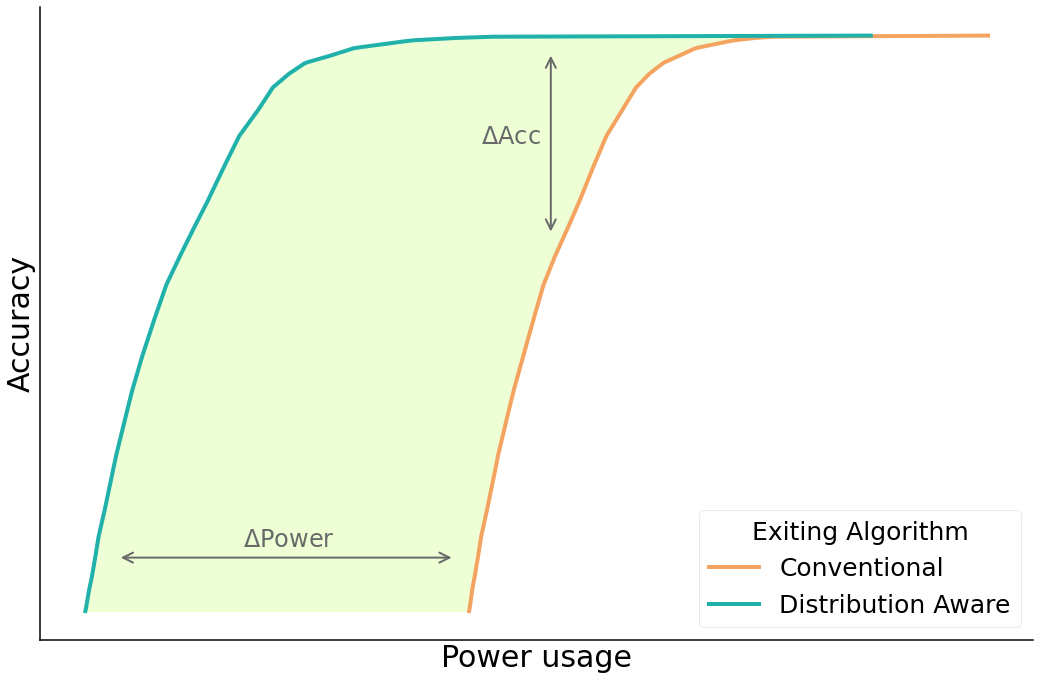

In [5]:
model_directory = 'trained-models/CIFAR10/resnet_4_branch/w1.0_d18/300-epoch/analysis'

fig,ax = plt.subplots(figsize = (15,10))

epsilon = 0.3
n_thresh = 35

base = run_adversarial_inference(model_directory,'CIFAR10',epsilon,n_thresh=n_thresh,knn_percentile=1.0,detect_ood=False,adaptive=False)
test = run_adversarial_inference(model_directory,'CIFAR10',epsilon,n_thresh=n_thresh,knn_percentile=0.99,detect_ood=True,adaptive=True)
base_acc = base['id_accuracy']
test_acc = test['id_accuracy']
base_powers=base['power_usage']
test_powers=test['power_usage']

acc_range = np.linspace(min(base_acc),max(base_acc),500)

interp_power_base = np.interp(acc_range,base_acc,base_powers)
interp_power_test = np.interp(acc_range,base_acc,test_powers)

arrowprops = dict(arrowstyle="<->", linewidth=2, color='dimgrey',connectionstyle="arc3")
ax.annotate('$\Delta$Power', xy=(0, 0), xycoords='figure fraction',xytext=(0.225,0.185), textcoords='figure fraction',fontsize=24,color='dimgrey')
ax.annotate("",xy=(0.11, 0.17), xycoords='figure fraction',xytext=(0.42, 0.17), textcoords='figure fraction',arrowprops=arrowprops)

ax.annotate('$\Delta$Acc', xy=(0, 0), xycoords='figure fraction',xytext=(0.445, 0.745), textcoords='figure fraction',fontsize=24,color='dimgrey')
ax.annotate("",xy=(0.51, 0.87), xycoords='figure fraction',xytext=(0.51, 0.62), textcoords='figure fraction',arrowprops=arrowprops)


plt.tight_layout()

ax.spines[['right', 'top']].set_visible(False)
ax.spines[['left', 'bottom']].set_linewidth(1.5)

ax.set_xticks([])
ax.set_yticks([])


plt.plot(interp_power_base,acc_range,label='Conventional',linewidth=4,color ='sandybrown')
plt.plot(interp_power_test,acc_range,label='Distribution Aware',linewidth=4,color='lightseagreen')
plt.fill_betweenx(acc_range,interp_power_base,interp_power_test,alpha=0.2,color =['greenyellow'])
    
plt.ylabel('Accuracy')
plt.xlabel('Power usage')
legend = plt.legend(title='Exiting Algorithm')
plt.setp(legend.get_title(), multialignment='center')
plt.tight_layout()
plt.savefig('main/figures/power_improvement_diagram.pdf',bbox_inches='tight')
plt.show()


In [10]:
def get_metrics_accuracy(model_directory,data,epsilon,n_thresh,percentile,detect_ood=True,adaptive=False,verbose=True):
    base_value_dict = run_adversarial_inference(model_directory,data,1.0,n_thresh=n_thresh,knn_percentile=1.0,detect_ood=False,adaptive=False)
    base_acc=base_value_dict['id_accuracy']
    base_powers=base_value_dict['power_usage']

    min_power = base_powers[0]
    min_power_acc = base_acc[0]

    func_out = run_adversarial_inference(model_directory,data,epsilon,n_thresh=n_thresh,knn_percentile=percentile,detect_ood=detect_ood,adaptive=adaptive)
    ood_powers,ood_acc=func_out['power_usage'],func_out['id_accuracy']
    
    #accuracy increase
    equiv_idx = np.argmin(np.abs(ood_powers-min_power))
    peak_accuracy_gain = (ood_acc[equiv_idx]-min_power_acc)*100

    #power increase      
    max_power_idx = np.argmax(base_powers - ood_powers)
    peak_power_gain = ((base_powers[max_power_idx] - ood_powers[max_power_idx])/base_powers[max_power_idx])*100

    if verbose:
        print('peak accuracy increase: ',np.round(peak_accuracy_gain,4))
        print('peak power increase: ',np.round(peak_power_gain,4))
    
    return peak_accuracy_gain,peak_power_gain
    

In [11]:
model_directory = 'trained-models/CIFAR10/resnet_4_branch/w1.0_d18/300-epoch/analysis/'
epsilons = np.load(model_directory + '../adversarial_analysis/epsilons.npy')
percentiles = [1.0,0.999,0.995,0.99,0.95,0.9]

for test_idx,epsilon in enumerate(epsilons[::3]):
    print('\nEpsilon:',np.round(epsilon,3))
    for percentile in percentiles:
        print('Percentile:',percentile)
        get_metrics_accuracy(model_directory,'CIFAR10',epsilon,n_thresh=50,percentile=percentile,detect_ood=True)


Epsilon: 0.0
Percentile: 1.0


KeyboardInterrupt: 

In [12]:
directories = ['trained-models/CIFAR100/resnet_4_branch/w1.0_d18/300-epoch/analysis',
               'trained-models/CIFAR100/resnet_4_branch/w1.0_d18/300-epoch_1/analysis',
               'trained-models/CIFAR100/resnet_4_branch/w1.0_d18/300-epoch_2/analysis',
               'trained-models/CIFAR100/resnet_4_branch/w1.0_d18/300-epoch_3/analysis',
               'trained-models/CIFAR100/resnet_4_branch/w1.0_d18/300-epoch_4/analysis']

epsilons = np.load(directories[0] + '/../adversarial_analysis/epsilons.npy')[::3]
percentiles = [1.0,0.999,0.995,0.99,0.95,0.9]

all_values = np.zeros((len(directories),len(epsilons),len(percentiles),2))

for dir_index,directory in enumerate(directories):
    print('in directory:',directory)
    for epsilon_idx,epsilon in enumerate(epsilons):
        print('\nepsilon:',epsilon)
        for p_index,percentile in enumerate(percentiles):
            print(percentile)
            acc,pow = get_metrics_accuracy(directory,'CIFAR100',epsilon,n_thresh=50,percentile=percentile,detect_ood=True,verbose=False)

            all_values[dir_index,epsilon_idx,p_index,0] = acc
            all_values[dir_index,epsilon_idx,p_index,1] = pow

np.save(directories[0]+'/peak_values_multirun_adv.npy',all_values) 

in directory: trained-models/CIFAR100/resnet_4_branch/w1.0_d18/300-epoch/analysis

epsilon: 0.0
1.0
0.999
0.995
0.99
0.95
0.9

epsilon: 0.1
1.0
0.999
0.995
0.99
0.95
0.9

epsilon: 0.2
1.0
0.999
0.995
0.99
0.95
0.9

epsilon: 0.3
1.0
0.999
0.995
0.99
0.95
0.9
in directory: trained-models/CIFAR100/resnet_4_branch/w1.0_d18/300-epoch_1/analysis

epsilon: 0.0
1.0
0.999
0.995
0.99
0.95
0.9

epsilon: 0.1
1.0
0.999
0.995
0.99
0.95
0.9

epsilon: 0.2
1.0
0.999
0.995
0.99
0.95
0.9

epsilon: 0.3
1.0
0.999
0.995
0.99
0.95
0.9
in directory: trained-models/CIFAR100/resnet_4_branch/w1.0_d18/300-epoch_2/analysis

epsilon: 0.0
1.0
0.999
0.995
0.99
0.95
0.9

epsilon: 0.1
1.0
0.999
0.995
0.99
0.95
0.9

epsilon: 0.2
1.0
0.999
0.995
0.99
0.95
0.9

epsilon: 0.3
1.0
0.999
0.995
0.99
0.95
0.9
in directory: trained-models/CIFAR100/resnet_4_branch/w1.0_d18/300-epoch_3/analysis

epsilon: 0.0
1.0
0.999
0.995
0.99
0.95
0.9

epsilon: 0.1
1.0
0.999
0.995
0.99
0.95
0.9

epsilon: 0.2
1.0
0.999
0.995
0.99
0.95
0.9

epsil

In [19]:
directory = 'trained-models/CIFAR100/resnet_4_branch/w1.0_d18/300-epoch/analysis'

all_vals = np.load(directory+'/peak_values_multirun_adv.npy')

epsilons = np.load(directories[0] + '/../adversarial_analysis/epsilons.npy')[::3]
percentiles = [1.0,0.999,0.995,0.99,0.95,0.9]


for epsilon_idx,epsilon in enumerate(epsilons):
    print('\nepsilon:',epsilon)
    for p_index,percentile in enumerate(percentiles):
        mean_acc = np.mean(all_vals[:,epsilon_idx,p_index,0])
        std_acc = np.std(all_vals[:,epsilon_idx,p_index,0])

        mean_power = np.mean(all_vals[:,epsilon_idx,p_index,1])
        std_power = np.std(all_vals[:,epsilon_idx,p_index,1])
        print(percentile,'\tacc:',np.round(mean_acc,2),'+-',np.round(std_acc,2))
        print(percentile,'\tpower:',np.round(mean_power,2),'+-',np.round(std_power,2))


epsilon: 0.0
1.0 	acc: 0.0 +- 0.0
1.0 	power: 0.0 +- 0.0
0.999 	acc: 0.08 +- 0.02
0.999 	power: 0.14 +- 0.0
0.995 	acc: 0.47 +- 0.03
0.995 	power: 0.68 +- 0.01
0.99 	acc: 1.14 +- 0.29
0.99 	power: 1.33 +- 0.01
0.95 	acc: 4.66 +- 0.62
0.95 	power: 6.23 +- 0.05
0.9 	acc: 6.47 +- 0.3
0.9 	power: 11.88 +- 0.09

epsilon: 0.1
1.0 	acc: 0.02 +- 0.03
1.0 	power: 0.02 +- 0.02
0.999 	acc: 0.46 +- 0.16
0.999 	power: 0.32 +- 0.07
0.995 	acc: 2.66 +- 0.6
0.995 	power: 1.6 +- 0.28
0.99 	acc: 4.89 +- 1.22
0.99 	power: 3.04 +- 0.37
0.95 	acc: 13.0 +- 1.22
0.95 	power: 11.57 +- 1.06
0.9 	acc: 14.47 +- 0.49
0.9 	power: 19.31 +- 1.18

epsilon: 0.2
1.0 	acc: 0.17 +- 0.21
1.0 	power: 0.14 +- 0.12
0.999 	acc: 4.29 +- 1.22
0.999 	power: 1.97 +- 0.48
0.995 	acc: 12.73 +- 3.62
0.995 	power: 6.81 +- 1.76
0.99 	acc: 17.49 +- 3.08
0.99 	power: 10.14 +- 2.04
0.95 	acc: 21.73 +- 1.73
0.95 	power: 20.21 +- 2.71
0.9 	acc: 17.47 +- 0.88
0.9 	power: 25.91 +- 2.31

epsilon: 0.3
1.0 	acc: 0.61 +- 0.43
1.0 	power: 0.48 +

Directory: trained-models/CIFAR100/resnet_4_branch/w1.0_d18/300-epoch/analysis
epsilon: 0.0
1.0 [100.  99.  95.  90.] [72.62 72.62 72.62 72.62]
0.999 [100.  99.  95.  90.] [72.62 72.72 72.76 72.79]
0.995 [100.  99.  95.  90.] [72.62  73.019 73.276 73.371]
0.99 [100.  99.  95.  90.] [72.62  73.262 73.804 74.107]
0.95 [100.  99.  95.  90.] [72.62  73.214 75.705 77.286]
0.9 [100.  99.  95.  90.] [72.62  73.249 75.493 78.292]
epsilon: 0.1
1.0 [100.  99.  95.  90.] [14.09 14.09 14.09 14.09]
0.999 [100.  99.  95.  90.] [14.09  15.087 15.452 15.57 ]
0.995 [100.  99.  95.  90.] [14.09  18.    19.577 20.335]
0.99 [100.  99.  95.  90.] [14.09  19.501 22.858 24.54 ]
0.95 [100.  99.  95.  90.] [14.09  18.822 35.693 44.72 ]
0.9 [100.  99.  95.  90.] [14.09  18.535 34.488 49.013]
epsilon: 0.2
1.0 [100.  99.  95.  90.] [6.53 6.53 6.53 6.53]
0.999 [100.  99.  95.  90.] [ 6.53  15.823 18.612 19.617]
0.995 [100.  99.  95.  90.] [ 6.53  35.45  42.042 44.815]
0.99 [100.  99.  95.  90.] [ 6.53  41.902 53.4

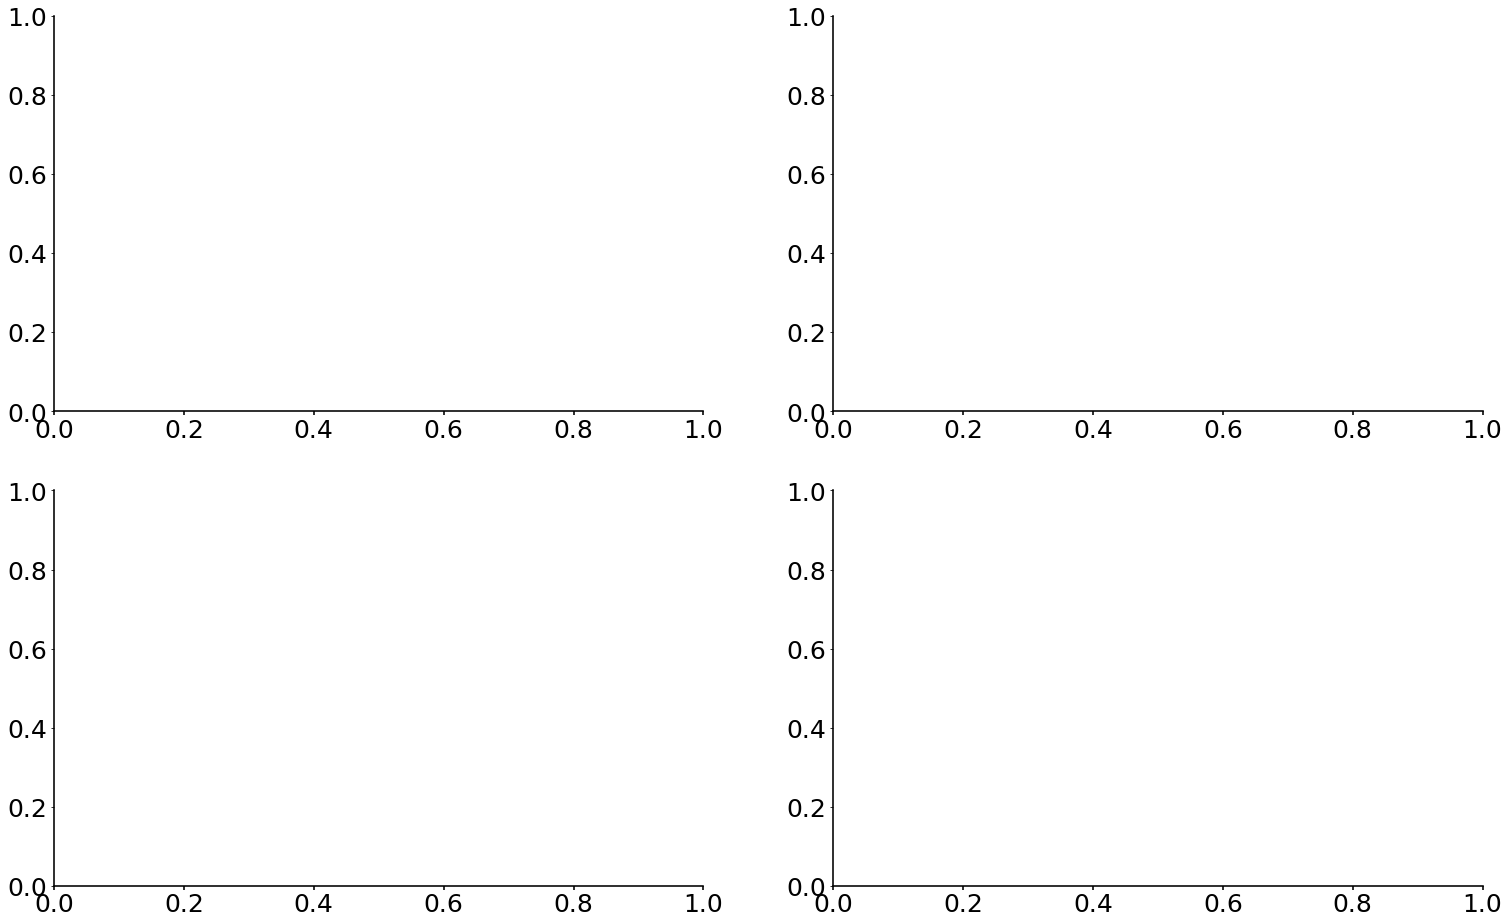

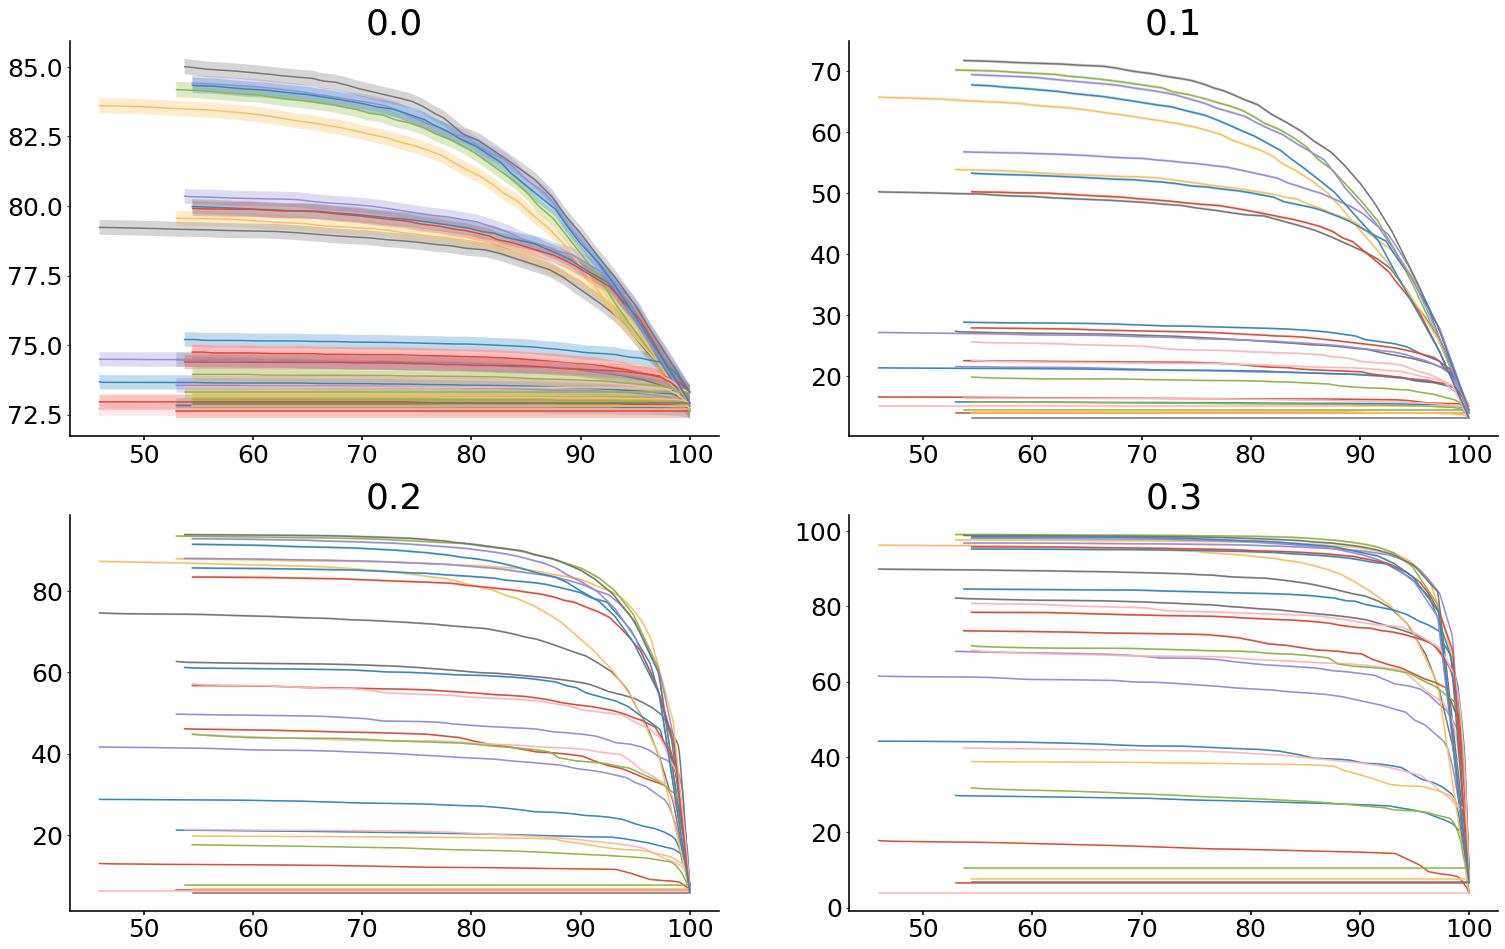

In [20]:
directories = ['trained-models/CIFAR100/resnet_4_branch/w1.0_d18/300-epoch/analysis',
               'trained-models/CIFAR100/resnet_4_branch/w1.0_d18/300-epoch_1/analysis',
               'trained-models/CIFAR100/resnet_4_branch/w1.0_d18/300-epoch_2/analysis',
               'trained-models/CIFAR100/resnet_4_branch/w1.0_d18/300-epoch_3/analysis',
               'trained-models/CIFAR100/resnet_4_branch/w1.0_d18/300-epoch_4/analysis']

n_branches=4
fig, axes = plt.subplots(2, int(n_branches/2))
epsilons = np.load(directories[0] + '/../adversarial_analysis/epsilons.npy')[::3]
percentiles = [1.0,0.999,0.995,0.99,0.95,0.9]
detection_values = np.zeros((len(directories),len(epsilons),len(percentiles),4))

fig, axes = plt.subplots(2, int(n_branches/2))
for dir_idx,directory in enumerate(directories):
    print('Directory:',directory)
    for epsilon_idx,epsilon in enumerate(epsilons):
        print('epsilon:',epsilon)
        ax = axes.flatten()[epsilon_idx]
        ax.set_title(epsilon)
        for p_index,percentile in enumerate(percentiles):
            accs,detect_accs = plot_adv_accuracy(ax,directory,'CIFAR100',epsilon,n_thresh=50,percentile=percentile,detect_ood=True,adaptive=True)
            print(percentile,accs,detect_accs)
            detection_values[dir_idx,epsilon_idx,p_index,:] = detect_accs
            
np.save(directories[0]+'/detection_accuracies_adv.npy',detection_values) 

In [21]:
directory = 'trained-models/CIFAR100/resnet_4_branch/w1.0_d18/300-epoch/analysis'

detection_accuracies_ood = np.load(directory+'/detection_accuracies_adv.npy')

epsilons = np.load(directories[0] + '/../adversarial_analysis/epsilons.npy')[::3]
percentiles = [1.0,0.999,0.995,0.99,0.95,0.9]

targets = np.array([100,99,95,90])

for epsilon_idx,epsilon in enumerate(epsilons):
    print('\n',epsilon)
    for t_index, target in enumerate(targets):
        print('target',target)
        for p_index,percentile in enumerate(percentiles):
            acc_mean = np.mean(detection_accuracies_ood[:,epsilon_idx,p_index,t_index])
            acc_std =  np.std(detection_accuracies_ood[:,epsilon_idx,p_index,t_index])
            print(percentile,'\tacc:',np.round(acc_mean,2),'+-',np.round(acc_std,2))


 0.0
target 100
1.0 	acc: 72.87 +- 0.24
0.999 	acc: 72.87 +- 0.24
0.995 	acc: 72.87 +- 0.24
0.99 	acc: 72.87 +- 0.24
0.95 	acc: 72.87 +- 0.24
0.9 	acc: 72.87 +- 0.24
target 99
1.0 	acc: 72.87 +- 0.24
0.999 	acc: 72.98 +- 0.23
0.995 	acc: 73.26 +- 0.22
0.99 	acc: 73.45 +- 0.23
0.95 	acc: 73.49 +- 0.27
0.9 	acc: 73.49 +- 0.25
target 95
1.0 	acc: 72.87 +- 0.24
0.999 	acc: 73.03 +- 0.24
0.995 	acc: 73.56 +- 0.25
0.99 	acc: 74.08 +- 0.26
0.95 	acc: 75.9 +- 0.4
0.9 	acc: 75.85 +- 0.41
target 90
1.0 	acc: 72.87 +- 0.24
0.999 	acc: 73.05 +- 0.23
0.995 	acc: 73.67 +- 0.27
0.99 	acc: 74.34 +- 0.23
0.95 	acc: 77.58 +- 0.39
0.9 	acc: 78.52 +- 0.41

 0.1
target 100
1.0 	acc: 14.19 +- 0.62
0.999 	acc: 14.19 +- 0.62
0.995 	acc: 14.19 +- 0.62
0.99 	acc: 14.19 +- 0.62
0.95 	acc: 14.19 +- 0.62
0.9 	acc: 14.19 +- 0.62
target 99
1.0 	acc: 14.19 +- 0.62
0.999 	acc: 14.87 +- 0.6
0.995 	acc: 17.18 +- 0.71
0.99 	acc: 18.43 +- 0.96
0.95 	acc: 18.77 +- 0.76
0.9 	acc: 18.54 +- 0.72
target 95
1.0 	acc: 14.19 +- 